<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#load-data" data-toc-modified-id="load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load data</a></span><ul class="toc-item"><li><span><a href="#read-in-the-files" data-toc-modified-id="read-in-the-files-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>read in the files</a></span><ul class="toc-item"><li><span><a href="#data-from-linear-and-relu-activations" data-toc-modified-id="data-from-linear-and-relu-activations-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>data from linear and relu activations</a></span></li></ul></li><li><span><a href="#create-pandas-table" data-toc-modified-id="create-pandas-table-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>create pandas table</a></span></li></ul></li><li><span><a href="#filter-out-bad-training-losses" data-toc-modified-id="filter-out-bad-training-losses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>filter out bad training losses</a></span></li><li><span><a href="#determine-the-lambda-parameter-that-gets-the-best-validation-MSE-for-each-(r,n,L)" data-toc-modified-id="determine-the-lambda-parameter-that-gets-the-best-test-MSE-for-each-(r,n,L)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>determine the lambda parameter that gets the best test MSE for each (r,n,L)</a></span></li><li><span><a href="#Generalization-MSE" data-toc-modified-id="Generalization-MSE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Generalization MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Out-of-Distribution-MSE" data-toc-modified-id="Out-of-Distribution-MSE-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Out of Distribution MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Active-Subspace" data-toc-modified-id="Active-Subspace-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Active Subspace</a></span><ul class="toc-item"><li><span><a href="#evaluate-gradients-and-compute-singular-values-and-active-subspaces" data-toc-modified-id="evaluate-gradients-and-compute-singular-values-and-active-subspaces-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>evaluate gradients and compute singular values and active subspaces</a></span></li><li><span><a href="#plot-of-singular-values" data-toc-modified-id="plot-of-singular-values-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>plot of singular values</a></span></li></ul></li><li><span><a href="#determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)" data-toc-modified-id="determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>determine the L parameter that gets the best test MSE for each (r,n)</a></span></li><li><span><a href="#Plots-of-L-vs-Test-error-and-n-vs-Generalization-metrics-with/without-linear-layers" data-toc-modified-id="Plots-of-L-vs-Validation-error-and-n-vs-Generalization-metrics-with/without-linear-layers-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plots of L vs Test error and n vs Generalization metrics with/without linear layers</a></span></li><li><span><a href="#Final-Table" data-toc-modified-id="Final-Table-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Final Table</a></span></li><li><span><a href="#Training-Time-Plots" data-toc-modified-id="Training-Time-Plots-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Training Time Plots</a></span><ul class="toc-item"><li><span><a href="#Train-MSE-v-Epoch" data-toc-modified-id="Train-MSE-v-Epoch-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Train MSE v Epoch</a></span></li><li><span><a href="#Weight-Decay-v-Epoch" data-toc-modified-id="Weight-Decay-v-Epoch-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Weight Decay v Epoch</a></span></li><li><span><a href="#learning-rates" data-toc-modified-id="learning-rates-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>learning rates</a></span></li></ul></li></ul></div>

# imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import ortho_group
from scipy.stats import linregress
from scipy import linalg as la
from torch import nn
import torch
import os
from matplotlib.lines import Line2D
from scipy.stats import sem

# load data

## read in the files

In [2]:
rnvals = [(1,64),(1,128),(1,256),(1,512),(1,1024),(1,2048),
          (2,64),(2,128),(2,256),(2,512),(2,1024),(2,2048)]
Ls = [2,3,4,5,6,7,8,9]
rs = [1,2]
wds = [1e-3,1e-4,1e-5]
labelnoise = [0,0.25,0.5,1]
epochs = 60100
job_name = "new_targets"

In [3]:
testMSEs = {}
trainMSEs = {}
weightdecays = {}
learningrates = {}
files_found_list = []
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            for ln in labelnoise:
                paramname = job_name+f"_labelnoise{ln}"+f"/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
                if os.path.exists(paramname+"testMSE.npy"):
                    testMSEs[r,n,L,wd,ln] = np.load(paramname+"testMSE.npy",allow_pickle=True).item()
                    trainMSEs[r,n,L,wd,ln] = np.load(paramname+"trainMSEs.npy",allow_pickle=True)
                    weightdecays[r,n,L,wd,ln] = np.load(paramname+"weightdecays.npy",allow_pickle=True)
                    learningrates[r,n,L,wd,ln] = np.load(paramname+"learningrates.npy",allow_pickle=True)
                    files_found_list.append((r,n,L,wd,ln))
                else:
                    print(f"{paramname+'testMSE.npy'} not found")

In [4]:
files_found_list

[(1, 64, 2, 0.001, 0),
 (1, 64, 2, 0.001, 0.25),
 (1, 64, 2, 0.001, 0.5),
 (1, 64, 2, 0.001, 1),
 (1, 64, 2, 0.0001, 0),
 (1, 64, 2, 0.0001, 0.25),
 (1, 64, 2, 0.0001, 0.5),
 (1, 64, 2, 0.0001, 1),
 (1, 64, 2, 1e-05, 0),
 (1, 64, 2, 1e-05, 0.25),
 (1, 64, 2, 1e-05, 0.5),
 (1, 64, 2, 1e-05, 1),
 (1, 64, 3, 0.001, 0),
 (1, 64, 3, 0.001, 0.25),
 (1, 64, 3, 0.001, 0.5),
 (1, 64, 3, 0.001, 1),
 (1, 64, 3, 0.0001, 0),
 (1, 64, 3, 0.0001, 0.25),
 (1, 64, 3, 0.0001, 0.5),
 (1, 64, 3, 0.0001, 1),
 (1, 64, 3, 1e-05, 0),
 (1, 64, 3, 1e-05, 0.25),
 (1, 64, 3, 1e-05, 0.5),
 (1, 64, 3, 1e-05, 1),
 (1, 64, 4, 0.001, 0),
 (1, 64, 4, 0.001, 0.25),
 (1, 64, 4, 0.001, 0.5),
 (1, 64, 4, 0.001, 1),
 (1, 64, 4, 0.0001, 0),
 (1, 64, 4, 0.0001, 0.25),
 (1, 64, 4, 0.0001, 0.5),
 (1, 64, 4, 0.0001, 1),
 (1, 64, 4, 1e-05, 0),
 (1, 64, 4, 1e-05, 0.25),
 (1, 64, 4, 1e-05, 0.5),
 (1, 64, 4, 1e-05, 1),
 (1, 64, 5, 0.001, 0),
 (1, 64, 5, 0.001, 0.25),
 (1, 64, 5, 0.001, 0.5),
 (1, 64, 5, 0.001, 1),
 (1, 64, 5, 0.0001

In [5]:
def Llayers(L,d=20,width=1000):
    #construct L-1 linear layers; bias term only on last linear layer
    if L < 2:
        raise ValueError("L must be at least 2")
    if L == 2:
        linear_layers = [nn.Linear(d,width,bias=True)]
    if L > 2:
        linear_layers = [nn.Linear(d,width,bias=False)]
        for l in range(L-3):
            linear_layers.append(nn.Linear(width,width,bias=False))
        linear_layers.append(nn.Linear(width,width,bias=True))

    relu = nn.ReLU()

    last_layer = nn.Linear(width,1)

    layers = linear_layers + [relu,last_layer]

    return nn.Sequential(*layers)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
files_found_list = []
models = {}
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            for ln in labelnoise:
                paramname = job_name+f"_labelnoise{ln}/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
                if os.path.exists(paramname+"model.pt"):
                    models[r,n,L,wd,ln] = Llayers(L,width=1000)
                    models[r,n,L,wd,ln].to(device)
                    if torch.cuda.is_available():
                        models[r,n,L,wd,ln].load_state_dict(torch.load(paramname+"model.pt"))
                    else:
                        models[r,n,L,wd,ln].load_state_dict(torch.load(paramname+"model.pt"),map_location=torch.device('cpu'))
                    models[r,n,L,wd,ln].eval()
                    files_found_list.append((r,n,L,wd,ln))
                else:
                    print(paramname+"model.pt","not found")

In [8]:
files_found_list

[(1, 64, 2, 0.001, 0),
 (1, 64, 2, 0.001, 0.25),
 (1, 64, 2, 0.001, 0.5),
 (1, 64, 2, 0.001, 1),
 (1, 64, 2, 0.0001, 0),
 (1, 64, 2, 0.0001, 0.25),
 (1, 64, 2, 0.0001, 0.5),
 (1, 64, 2, 0.0001, 1),
 (1, 64, 2, 1e-05, 0),
 (1, 64, 2, 1e-05, 0.25),
 (1, 64, 2, 1e-05, 0.5),
 (1, 64, 2, 1e-05, 1),
 (1, 64, 3, 0.001, 0),
 (1, 64, 3, 0.001, 0.25),
 (1, 64, 3, 0.001, 0.5),
 (1, 64, 3, 0.001, 1),
 (1, 64, 3, 0.0001, 0),
 (1, 64, 3, 0.0001, 0.25),
 (1, 64, 3, 0.0001, 0.5),
 (1, 64, 3, 0.0001, 1),
 (1, 64, 3, 1e-05, 0),
 (1, 64, 3, 1e-05, 0.25),
 (1, 64, 3, 1e-05, 0.5),
 (1, 64, 3, 1e-05, 1),
 (1, 64, 4, 0.001, 0),
 (1, 64, 4, 0.001, 0.25),
 (1, 64, 4, 0.001, 0.5),
 (1, 64, 4, 0.001, 1),
 (1, 64, 4, 0.0001, 0),
 (1, 64, 4, 0.0001, 0.25),
 (1, 64, 4, 0.0001, 0.5),
 (1, 64, 4, 0.0001, 1),
 (1, 64, 4, 1e-05, 0),
 (1, 64, 4, 1e-05, 0.25),
 (1, 64, 4, 1e-05, 0.5),
 (1, 64, 4, 1e-05, 1),
 (1, 64, 5, 0.001, 0),
 (1, 64, 5, 0.001, 0.25),
 (1, 64, 5, 0.001, 0.5),
 (1, 64, 5, 0.001, 1),
 (1, 64, 5, 0.0001

## create pandas table

In [9]:
res = {
  "r"                                    : [r                          for r,n,L,wd,ln in files_found_list],# + [r                         for wd in wds for r,n in relu_rnvals],
  "label noise standard deviation"       : [ln                         for r,n,L,wd,ln in files_found_list],# + [ln                        for wd in wds for r,n in relu_rnvals],
  "n"                                    : [n                          for r,n,L,wd,ln in files_found_list],# + [n                         for wd in wds for r,n in relu_rnvals],
  "L"                                    : [L                          for r,n,L,wd,ln in files_found_list],# + [4                         for wd in wds for r,n in relu_rnvals],
  "lambda"                               : [wd                         for r,n,L,wd,ln in files_found_list],# + [wd                        for wd in wds for r,n in relu_rnvals],
  "Learning Rate"                        : [learningrates[r,n,L,wd,ln] for r,n,L,wd,ln in files_found_list],# + [RELUlearningrates[r,n][4][wd] for wd in wds for r,n in relu_rnvals],
  "Train MSE"                            : [trainMSEs[r,n,L,wd,ln]     for r,n,L,wd,ln in files_found_list],# + [RELUtrainMSEs[r,n][4][wd]     for wd in wds for r,n in relu_rnvals],
  "Weight Decay"                         : [weightdecays[r,n,L,wd,ln]  for r,n,L,wd,ln in files_found_list],# + [RELUweightdecays[r,n][4][wd]  for wd in wds for r,n in relu_rnvals],
  "Model"                                : [models[r,n,L,wd,ln]        for r,n,L,wd,ln in files_found_list],# + [RELUmodels[r,n,4,wd]          for wd in wds for r,n in relu_rnvals],
  "Test MSE"                             : [testMSEs[r,n,L,wd,ln]      for r,n,L,wd,ln in files_found_list],# + [RELUtestMSEs[r,n][4][wd].item()      for wd in wds for r,n in relu_rnvals],
  "Activations"                          : ["linear and relu"          for r,n,L,wd,ln in files_found_list],# + ["relu only"         for wd in wds for r,n in relu_rnvals]
}
res = pd.DataFrame(res)
res["Final Train MSE"] = [r[-1] for r in res["Train MSE"]]
res["Final Weight Decay"] = [r[-1] for r in res["Weight Decay"]]
res

,r,label noise standard deviation,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,linear and relu,1.341431e-05,224.599670
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,linear and relu,5.777340e-06,232.962372
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,linear and relu,2.933852e-06,243.854279
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,linear and relu,8.222866e-07,270.989899
4,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,linear and relu,5.553246e-08,226.878784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2,1.00,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.843381, 4.1538687, 4.0898495, 4.112174, 4.0...","[29353.979, 29336.143, 29325.576, 29313.77, 29...","[Linear(in_features=20, out_features=1000, bia...",1.051062,linear and relu,8.801726e-01,1423.843750
1148,2,0.00,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9311483, 3.126759, 3.0239534, 3.2637768, 3....","[29418.832, 29405.988, 29402.477, 29401.318, 2...","[Linear(in_features=20, out_features=1000, bia...",0.000005,linear and relu,4.186356e-06,793.465820
1149,2,0.25,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9806905, 3.2087455, 3.1139393, 3.2826471, 3...","[29418.32, 29405.709, 29402.227, 29400.758, 29...","[Linear(in_features=20, out_features=1000, bia...",0.079065,linear and relu,4.259164e-02,2450.782715
1150,2,0.50,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.1494136, 3.4205222, 3.316286, 3.436524, 3.2...","[29417.41, 29405.28, 29401.941, 29399.887, 293...","[Linear(in_features=20, out_features=1000, bia...",0.442928,linear and relu,1.006398e-01,4212.969727


# Initial Training Time Checks


## Train MSE v Epoch


In [10]:
# for ln in labelnoise:
#     for lamb in wds:
#         f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
#         plt.figure(figsize=(10,10))
#         for rownum,row in res.iterrows():
#             if row["L"] <= 4 and row["label noise standard deviation"] == ln and row["lambda"] == lamb:
#                 whichrow = np.where(row['r'] == res.r.unique())[0][0]
#                 whichcol = np.where(row['n'] == res.n.unique())[0][0]
#                 ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
#                 ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
#                 ax[whichrow,whichcol].set_xlabel("Epoch")
#         ax[0,0].legend()
#         f.suptitle(rf"Train MSE v Epoch (label noise $N(0,{ln**2})$, weight decay $\lambda$ = {lamb})")
#         f.savefig(job_name+f"_labelnoise{ln}/trainmse234_lamb{lamb}.png",dpi=300)
#         plt.show()
#         f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
#         plt.figure(figsize=(10,10))
#         for rownum,row in res.iterrows():
#             if 4 < row["L"] <= 7 and row["label noise standard deviation"] == ln and row["lambda"] == lamb:
#                 whichrow = np.where(row['r'] == res.r.unique())[0][0]
#                 whichcol = np.where(row['n'] == res.n.unique())[0][0]
#                 ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
#                 ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
#                 ax[whichrow,whichcol].set_xlabel("Epoch")
#         ax[0,0].legend()
#         f.suptitle(rf"Train MSE v Epoch (label noise $N(0,{ln**2})$, weight decay $\lambda$ = {lamb})")
#         f.savefig(job_name+f"_labelnoise{ln}/trainmse567_lamb{lamb}.png",dpi=300)
#         plt.show()
#         f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))
#         plt.figure(figsize=(10,10))
#         for rownum,row in res.iterrows():
#             if row["L"] > 7 and row["label noise standard deviation"] == ln and row["lambda"] == lamb:
#                 whichrow = np.where(row['r'] == res.r.unique())[0][0]
#                 whichcol = np.where(row['n'] == res.n.unique())[0][0]
#                 ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
#                 ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
#                 ax[whichrow,whichcol].set_xlabel("Epoch")
#         ax[0,0].legend()
#         f.suptitle(rf"Train MSE v Epoch (label noise $N(0,{ln**2})$, weight decay $\lambda$ = {lamb})")
#         f.savefig(job_name+f"_labelnoise{ln}/trainmse8910_lamb{lamb}.png",dpi=300)
#         plt.show()

## Weight Decay v Epoch


In [11]:
# for ln in labelnoise:
#     for lamb in wds:
#         f, ax = plt.subplots(len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
#         plt.figure(figsize=(10,10))
#         for rownum,row in res.iterrows():
#             if row["label noise standard deviation"] == ln and row["lambda"] == lamb:
#                 whichrow = np.where(row['r'] == res.r.unique())[0][0]
#                 whichcol = np.where(row['n'] == res.n.unique())[0][0]
#                 ax[whichrow,whichcol].semilogy(row["Weight Decay"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
#                 ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
#                 ax[whichrow,whichcol].set_xlabel("Epoch")
#         ax[0,0].legend()
#         f.suptitle(rf"Weight Decay v Epoch (label noise $N(0,{ln**2})$, weight decay $\lambda$ = {lamb})")
#         f.savefig(job_name+f"_labelnoise{ln}/weightdecay_lamb{lamb}.png",dpi=300)
#         plt.show()

## learning rates


In [12]:
# for ln in labelnoise:
#     for lamb in wds:
#         f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
#         plt.figure(figsize=(10,10))
#         for rownum,row in res.iterrows():
#             if row["label noise standard deviation"] == ln and row["lambda"] == lamb:
#                     whichrow = np.where(row['r'] == res.r.unique())[0][0]
#                     whichcol = np.where(row['n'] == res.n.unique())[0][0]
#                     ax[whichrow,whichcol].semilogy(row["Learning Rate"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
#                     ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
#                     ax[whichrow,whichcol].set_xlabel("Epoch")
#         ax[0,0].legend()
#         f.suptitle(rf"Learning Rate v Epoch (label noise $N(0,{ln**2})$, weight decay $\lambda$ = {lamb})")
#         f.savefig(job_name+f"_labelnoise{ln}/LearningRate_lamb{lamb}.png",dpi=300)
#         plt.show()

# filter out bad training losses

In [13]:
trainMSE_threshold = 1e-2

In [14]:
res[res["Final Train MSE"] >= trainMSE_threshold + res["label noise standard deviation"]] #TODO is this reasonable?

,r,label noise standard deviation,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay


In [15]:
res = res[res["Final Train MSE"] < trainMSE_threshold + res["label noise standard deviation"]]
res

,r,label noise standard deviation,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,linear and relu,1.341431e-05,224.599670
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,linear and relu,5.777340e-06,232.962372
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,linear and relu,2.933852e-06,243.854279
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,linear and relu,8.222866e-07,270.989899
4,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,linear and relu,5.553246e-08,226.878784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2,1.00,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.843381, 4.1538687, 4.0898495, 4.112174, 4.0...","[29353.979, 29336.143, 29325.576, 29313.77, 29...","[Linear(in_features=20, out_features=1000, bia...",1.051062,linear and relu,8.801726e-01,1423.843750
1148,2,0.00,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9311483, 3.126759, 3.0239534, 3.2637768, 3....","[29418.832, 29405.988, 29402.477, 29401.318, 2...","[Linear(in_features=20, out_features=1000, bia...",0.000005,linear and relu,4.186356e-06,793.465820
1149,2,0.25,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9806905, 3.2087455, 3.1139393, 3.2826471, 3...","[29418.32, 29405.709, 29402.227, 29400.758, 29...","[Linear(in_features=20, out_features=1000, bia...",0.079065,linear and relu,4.259164e-02,2450.782715
1150,2,0.50,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.1494136, 3.4205222, 3.316286, 3.436524, 3.2...","[29417.41, 29405.28, 29401.941, 29399.887, 293...","[Linear(in_features=20, out_features=1000, bia...",0.442928,linear and relu,1.006398e-01,4212.969727


# generate data function


In [16]:
def gen_data(datasetsize,r,seed,std,labelnoiseseed,trainsize=2**18,testsize=2**10,d=20,funcseed=42,verbose=False,ood=False):

    ##Generate data with a true central subspaces of varying dimensions
    #generate X values for training and test sets
    np.random.seed(seed) #set seed for data generation
    trainX = np.random.rand(d,trainsize).astype(np.float32)[:,:datasetsize] - 0.5 #distributed as U[-1/2, 1/2]
    testX = np.random.rand(d,testsize).astype(np.float32) - 0.5 #distributed as U[-1/2, 1/2]
    #out of distribution datagen
    if ood:
        trainX *= 2 #now distributed as U[-1, 1]
        testX *= 2 #now distributed as U[-1, 1]
    ##for each $r$ value create and store data-gen functions and $y$ evaluations
    #geneate params for functions
    k = d+1
    U = np.load(job_name+f"_labelnoise{std}/r{r}U.npy")
    Sigma = np.load(job_name+f"_labelnoise{std}/r{r}Sigma.npy")
    V = np.load(job_name+f"_labelnoise{std}/r{r}V.npy")
    A = np.load(job_name+f"_labelnoise{std}/r{r}A.npy")
    B = np.load(job_name+f"_labelnoise{std}/r{r}B.npy")
    #create functions
    np.random.seed(labelnoiseseed) #set seed for data generation
    def g(z): #active subspace function
        hidden_layer = (U*Sigma)@z
        hidden_layer = hidden_layer.T + B
        hidden_layer = np.maximum(0,hidden_layer).T
        return A@hidden_layer
    def f(x): #teacher network
        z = V.T@x    
        eps = std*np.random.randn(x.shape[1])    
        return g(z) + eps
    #generate data
    trainY = f(trainX).astype(np.float32)
    testY = f(testX).astype(np.float32)
    #move data to device
    if verbose:
        print("device: {}".format(device))
    trainX = torch.from_numpy(trainX).T.to(device)
    trainY = torch.from_numpy(trainY).to(device)
    testX = torch.from_numpy(testX).T.to(device)
    testY = torch.from_numpy(testY).to(device)
    if verbose:
        print("trainX shape = {} trainY shape = {}".format(
            trainX.shape,
            trainY.shape
        ))
    return trainX,trainY,testX,testY


# Validation MSE


## generate data


In [17]:
validationY = {}

validationsize = 2048
for r in rs:
    for k,std in enumerate(labelnoise):
        labelnoiseseed = 686 + k
        datagenseed = 1107
        print("validation size =",validationsize,"r =",r,"label noise std =",std,"label noise seed =",labelnoiseseed)
        validationX,validationY[r,std] = gen_data(datasetsize=validationsize,r=r,seed=datagenseed,std=std,labelnoiseseed=labelnoiseseed)[:2]
validationX.min(),validationX.max()


validation size = 2048 r = 1 label noise std = 0 label noise seed = 686
validation size = 2048 r = 1 label noise std = 0.25 label noise seed = 687
validation size = 2048 r = 1 label noise std = 0.5 label noise seed = 688
validation size = 2048 r = 1 label noise std = 1 label noise seed = 689
validation size = 2048 r = 2 label noise std = 0 label noise seed = 686
validation size = 2048 r = 2 label noise std = 0.25 label noise seed = 687
validation size = 2048 r = 2 label noise std = 0.5 label noise seed = 688
validation size = 2048 r = 2 label noise std = 1 label noise seed = 689


(tensor(-0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))

## compute squared errors


In [18]:
with torch.no_grad():
    validation = []
    normalized_validation = []
    squared_errors = []
    validation_sem = []
    validation_std = []
    for rownum, row in res.iterrows():
        std = row["label noise standard deviation"]
        predY = row["Model"](validationX)
        squared_err = (predY[:,0] - validationY[row["r"],std])**2
        squared_err = squared_err.cpu().numpy()
        mse = nn.functional.mse_loss(predY[:,0],validationY[row["r"],std]).item()
        assert np.isclose(mse,np.mean(squared_err))
        validation.append(mse)
        sem_sqared_err = sem(squared_err)
        validation_sem.append(sem_sqared_err)
        std_sqared_err = np.std(squared_err)
        validation_std.append(std_sqared_err)
        if std > 0:
            normalized_validation.append(mse/(std**2))
        else:
            normalized_validation.append(np.nan)
        squared_errors.append(squared_err)
    res["Validation MSE"] = validation
    res["Validation MSE$/\sigma^2$"] = normalized_validation
    res["Validation Squared Errors"] = squared_errors
    res["Validation SEM"] = validation_sem
    res["Validation STD of Squared Errors"] = validation_std
res

,r,label noise standard deviation,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay,Validation MSE,Validation MSE$/\sigma^2$,Validation Squared Errors,Validation SEM,Validation STD of Squared Errors
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,linear and relu,1.341431e-05,224.599670,0.016170,NaN,"[0.00016536887, 0.00055736996, 0.012135972, 0....",1.897142e-03,0.085834
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,linear and relu,5.777340e-06,232.962372,0.196858,3.149720,"[0.047511395, 0.42259312, 0.22228272, 0.204517...",6.768054e-03,0.306212
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,linear and relu,2.933852e-06,243.854279,0.715122,2.860486,"[1.5282708, 1.1073704, 0.4331878, 0.6494131, 0...",2.324565e-02,1.051721
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,linear and relu,8.222866e-07,270.989899,2.548462,2.548462,"[0.20293018, 0.06598258, 0.0017223269, 0.55333...",8.663294e-02,3.919602
4,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,linear and relu,5.553246e-08,226.878784,0.030106,NaN,"[0.00012912386, 0.0035010616, 0.03244231, 0.01...",2.302237e-03,0.104162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2,1.00,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.843381, 4.1538687, 4.0898495, 4.112174, 4.0...","[29353.979, 29336.143, 29325.576, 29313.77, 29...","[Linear(in_features=20, out_features=1000, bia...",1.051062,linear and relu,8.801726e-01,1423.843750,1.071401,1.071401,"[0.26118207, 0.9932619, 0.35466397, 0.55603135...",3.355892e-02,1.518333
1148,2,0.00,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9311483, 3.126759, 3.0239534, 3.2637768, 3....","[29418.832, 29405.988, 29402.477, 29401.318, 2...","[Linear(in_features=20, out_features=1000, bia...",0.000005,linear and relu,4.186356e-06,793.465820,0.000004,NaN,"[2.513002e-06, 3.7479367e-06, 1.0855331e-08, 2...",5.863767e-07,0.000027
1149,2,0.25,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9806905, 3.2087455, 3.1139393, 3.2826471, 3...","[29418.32, 29405.709, 29402.227, 29400.758, 29...","[Linear(in_features=20, out_features=1000, bia...",0.079065,linear and relu,4.259164e-02,2450.782715,0.077548,1.240771,"[0.008216529, 0.041220017, 0.04544737, 0.03442...",2.484017e-03,0.112386
1150,2,0.50,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.1494136, 3.4205222, 3.316286, 3.436524, 3.2...","[29417.41, 29405.28, 29401.941, 29399.887, 293...","[Linear(in_features=20, out_features=1000, bia...",0.442928,linear and relu,1.006398e-01,4212.969727,0.440972,1.763887,"[1.560701, 0.104476415, 0.1401253, 0.031048845...",1.581635e-02,0.715592


# Generalization MSE

## generate data

In [19]:
generalizationY = {}
generalizationsize = 2048
for r in rs:
    for k,std in enumerate(labelnoise):
        labelnoiseseed = 743 + k
        datagenseed = 555
        print("generalization size =",generalizationsize,"r =",r,"label noise std =",std,"label noise seed =",labelnoiseseed)
        generalizationX,generalizationY[r,std] = gen_data(datasetsize=generalizationsize,r=r,seed=datagenseed,std=std,labelnoiseseed=labelnoiseseed)[:2]

generalization size = 2048 r = 1 label noise std = 0 label noise seed = 743
generalization size = 2048 r = 1 label noise std = 0.25 label noise seed = 744
generalization size = 2048 r = 1 label noise std = 0.5 label noise seed = 745
generalization size = 2048 r = 1 label noise std = 1 label noise seed = 746
generalization size = 2048 r = 2 label noise std = 0 label noise seed = 743
generalization size = 2048 r = 2 label noise std = 0.25 label noise seed = 744
generalization size = 2048 r = 2 label noise std = 0.5 label noise seed = 745
generalization size = 2048 r = 2 label noise std = 1 label noise seed = 746


In [20]:
generalizationX.min(),generalizationX.max()

(tensor(-0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))

## compute squared errors

In [21]:
with torch.no_grad():
    generalization = []
    normalized_generalization = []
    squared_errors = []
    generalization_sem = []
    generalization_std = []
    for rownum, row in res.iterrows():
        std = row["label noise standard deviation"]
        predY = row["Model"](generalizationX)
        squared_err = (predY[:,0] - generalizationY[row["r"],std])**2
        squared_err = squared_err.cpu().numpy()
        mse = nn.functional.mse_loss(predY[:,0],generalizationY[row["r"],std]).item()
        assert np.isclose(mse,np.mean(squared_err))
        generalization.append(mse)
        sem_sqared_err = sem(squared_err)
        generalization_sem.append(sem_sqared_err)
        std_sqared_err = np.std(squared_err)
        generalization_std.append(std_sqared_err)
        if std > 0:
            normalized_generalization.append(mse/(std**2))
        else:
            normalized_generalization.append(np.nan)
        squared_errors.append(squared_err)
    res["Generalization MSE"] = generalization
    res["Generalization MSE$/\sigma^2$"] = normalized_generalization
    res["Generalization Squared Errors"] = squared_errors
    res["Generalization SEM"] = generalization_sem
    res["Generalization STD of Squared Errors"] = generalization_std

# Out of Distribution MSE

## generate data

In [22]:
oodY = {}
oodsize = 2048
for r in rs:
    for k,std in enumerate(labelnoise):
        labelnoiseseed = 235 + k
        datagenseed = 333
        print("ood size =",oodsize,"r =",r,"label noise std =",std,"label noise seed =",labelnoiseseed)
        oodX,oodY[r,std] = gen_data(datasetsize=oodsize,r=r,seed=datagenseed,std=std,labelnoiseseed=labelnoiseseed,ood=True)[:2]

ood size = 2048 r = 1 label noise std = 0 label noise seed = 235
ood size = 2048 r = 1 label noise std = 0.25 label noise seed = 236
ood size = 2048 r = 1 label noise std = 0.5 label noise seed = 237
ood size = 2048 r = 1 label noise std = 1 label noise seed = 238
ood size = 2048 r = 2 label noise std = 0 label noise seed = 235
ood size = 2048 r = 2 label noise std = 0.25 label noise seed = 236
ood size = 2048 r = 2 label noise std = 0.5 label noise seed = 237
ood size = 2048 r = 2 label noise std = 1 label noise seed = 238


In [23]:
oodX.min(),oodX.max()

(tensor(-1.0000, device='cuda:0'), tensor(0.9999, device='cuda:0'))

## compute squared errors

In [24]:
with torch.no_grad():
    ood = []
    normalized_ood = []
    squared_errors = []
    ood_sem = []
    ood_std = []
    for rownum, row in res.iterrows():
        std = row["label noise standard deviation"]
        predY = row["Model"](oodX)
        squared_err = (predY[:,0] - oodY[row["r"],std])**2
        squared_err = squared_err.cpu().numpy()
        mse = nn.functional.mse_loss(predY[:,0],oodY[row["r"],std]).item()
        assert np.isclose(mse,np.mean(squared_err))
        ood.append(mse)
        sem_sqared_err = sem(squared_err)
        ood_sem.append(sem_sqared_err)
        std_sqared_err = np.std(squared_err)
        ood_std.append(std_sqared_err)
        if std > 0:
            normalized_ood.append(mse/(std**2))
        else:
            normalized_ood.append(np.nan)
        squared_errors.append(squared_err)
    res["Out of Distribution MSE"] = ood
    res["Out of Distribution MSE$/\sigma^2$"] = normalized_ood
    res["Out of Distribution Squared Errors"] = squared_errors
    res["Out of Distribution SEM"] = ood_sem
    res["Out of Distribution STD of Squared Errors"] = ood_std

# Check that most or all ReLU hyperplanes intersect the support of the distributions of the tests

It is straightforward to prove that the hyperplane
$$\mathbf w ^\top \mathbf x + b = 0$$
intersects the hypercube $$\|\mathbf x\|_\infty \le t$$
if and only if $$t  \ge \frac{|b|}{\|\mathbf w\|_1}.$$

Therefore given a ReLU units $(a_k, \mathbf w_k, b_k)$, if
- **$\frac{|b_k|}{\|\mathbf w_k\|_1} \le \frac{1}{2}$:** then the  hyperplane intersects the support of the distribution for the **"in-distribution"** tests.
- **$\frac{|b_k|}{\|\mathbf w_k\|_1} \in (\frac{1}{2},1]$:** then the hyperplane intersects the support of the distribution for the **"out-of-distribution"** tests but not the "in-distribution" tests
- **$\frac{|b_k|}{\|\mathbf w_k\|_1} > 1$:** then the hyperplanes intersects **neither** the support of the distribution for the "out-of-distribution" tests nor the "in-distribution" tests

r = 1

TOTALS:
~~~~~~~
 R2-cost contribution         129.775677
|b| / ||w||_1                  1.718445
# training active          23158.000000
% training active             11.307617
# validation active        23138.000000
% validation active           11.297852
# generalization active    23137.000000
% generalization active       11.297363
# ood active               23299.000000
% ood active                  11.376465
dtype: float64

unit-wise table:
~~~~~~~



,R2-cost contribution,|b| / ||w||_1,# training active,% training active,# validation active,% validation active,# generalization active,% generalization active,# ood active,% ood active
0,5.239101,0.017410,865,0.422363,894,0.436523,868,0.423828,956,0.466797
1,0.780412,0.025086,1252,0.611328,1215,0.593262,1247,0.608887,1118,0.545898
2,0.438060,0.113275,231,0.112793,216,0.105469,225,0.109863,563,0.274902
3,8.485826,0.009074,1108,0.541016,1078,0.526367,1115,0.544434,1060,0.517578
4,5.722474,0.000186,1028,0.501953,992,0.484375,1029,0.502441,1027,0.501465
5,9.581510,0.001485,1002,0.489258,1045,0.510254,1003,0.489746,1013,0.494629
6,9.344744,0.002883,1053,0.514160,1018,0.497070,1054,0.514648,1041,0.508301
7,11.159105,0.007599,1095,0.534668,1059,0.517090,1099,0.536621,1054,0.514648
8,0.406547,0.019168,855,0.417480,836,0.408203,883,0.431152,937,0.457520
9,5.524434,0.003632,1064,0.519531,1024,0.500000,1066,0.520508,1042,0.508789


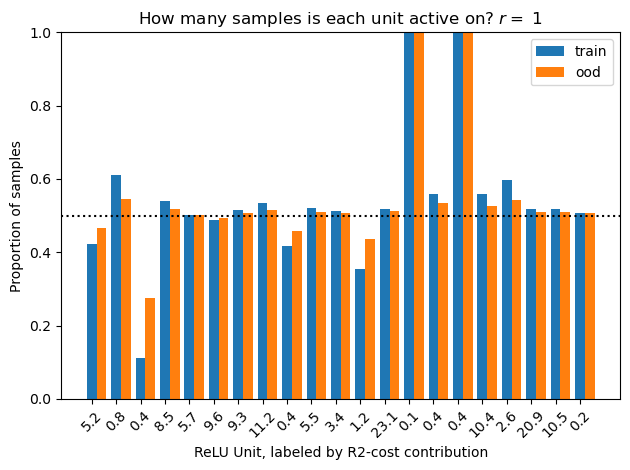

r = 2

TOTALS:
~~~~~~~
 R2-cost contribution         223.147503
|b| / ||w||_1                  0.230783
# training active          21379.000000
% training active             10.438965
# validation active        21284.000000
% validation active           10.392578
# generalization active    21298.000000
% generalization active       10.399414
# ood active               21360.000000
% ood active                  10.429688
dtype: float64

unit-wise table:
~~~~~~~



,R2-cost contribution,|b| / ||w||_1,# training active,% training active,# validation active,% validation active,# generalization active,% generalization active,# ood active,% ood active
0,2.021811,0.021495,775,0.378418,782,0.381836,784,0.382812,925,0.451660
1,0.402139,0.043486,1449,0.707520,1446,0.706055,1453,0.709473,1220,0.595703
2,1.278993,0.023220,808,0.394531,753,0.367676,787,0.384277,887,0.433105
3,4.191544,0.007405,995,0.485840,976,0.476562,968,0.472656,982,0.479492
4,21.394932,0.013318,1185,0.578613,1138,0.555664,1165,0.568848,1046,0.510742
5,9.869071,0.007666,1082,0.528320,1126,0.549805,1102,0.538086,1080,0.527344
6,5.596780,0.010253,1164,0.568359,1118,0.545898,1145,0.559082,1035,0.505371
7,9.045827,0.005964,1148,0.560547,1108,0.541016,1102,0.538086,1045,0.510254
8,3.535087,0.006273,1102,0.538086,1089,0.531738,1068,0.521484,1037,0.506348
9,9.782236,0.000971,1071,0.522949,1030,0.502930,1059,0.517090,1002,0.489258


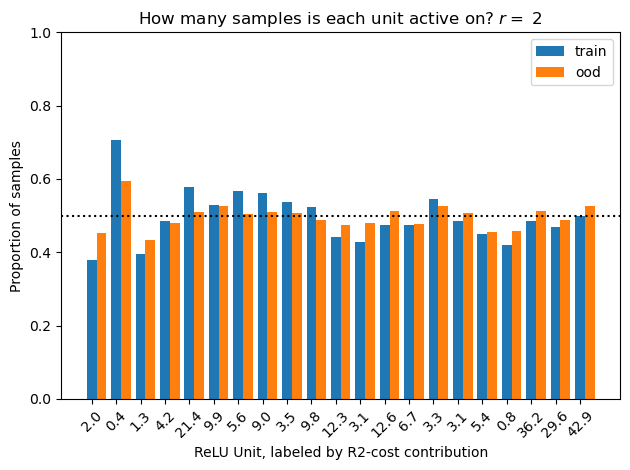

In [25]:
for r in rs:
    print("r =",r)
    U = np.load(job_name+f"_labelnoise0/r{r}U.npy")
    Sigma = np.load(job_name+f"_labelnoise0/r{r}Sigma.npy")
    V = np.load(job_name+f"_labelnoise0/r{r}V.npy")
    A = np.load(job_name+f"_labelnoise0/r{r}A.npy")
    B = np.load(job_name+f"_labelnoise0/r{r}B.npy")
    W = (U*Sigma)@V.T
    rowwise1norms = np.linalg.norm(W,axis=1,ord=1)
    ratios = np.abs(B) / np.linalg.norm(W,axis=1,ord=1)
    rowwise2norms = np.linalg.norm(W,axis=1,ord=2)
    units = pd.DataFrame({"R2-cost contribution":np.abs(A)*rowwise2norms,"|b| / ||w||_1":ratios})
    # units["[-1/2,1/2]"] = ratios <= 1/2
    # units["[-1,1] but not [-1/2,1/2]"] = (1/2 < ratios) * (ratios <= 1)
    # units["not [-1,1]"] = ratios > 1

    datasetsize = 2048
    trainX = gen_data(datasetsize=datasetsize,r=r,seed=1,std=0,labelnoiseseed=0)[0]
    units["# training active"] = ((W@trainX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% training active"] = units["# training active"] / datasetsize
    units["# validation active"] = ((W@validationX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% validation active"] = units["# validation active"] / datasetsize
    units["# generalization active"] = ((W@generalizationX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% generalization active"] = units["# generalization active"] / datasetsize
    units["# ood active"] = ((W@oodX.cpu().numpy().T).T + B > 0).sum(axis=0)
    units["% ood active"] = units["# ood active"] / datasetsize

    print("\nTOTALS:\n~~~~~~~\n",units.sum())
    print("\nunit-wise table:\n~~~~~~~\n")
    display(units)
    plt.bar(units.index-0.2,units["# training active"]/datasetsize,label="train",width=0.4,tick_label=units["R2-cost contribution"].round(1))
    # plt.bar(units.index,units["# generalization active"]/datasetsize,label="gen",width=0.4)
    plt.bar(units.index+0.2,units["# ood active"]/datasetsize,label="ood",width=0.4)
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.title(f"How many samples is each unit active on? $r =$ {r}")
    plt.xlabel("ReLU Unit, labeled by R2-cost contribution")
    plt.ylabel("Proportion of samples")
    plt.axhline(0.5,linestyle=":",color="k")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"samples_active_by_unit_r{r}")
    plt.show()


# Active Subspace

## evaluate gradients and compute singular values and active subspaces

In [26]:
grads = []
sv = []
active_subspace = []
subspace_dist = []

for rownum, row in res.iterrows():
    #compute ground truth active subspace
    funcseed = 42
    d = 20
    k = d+1
    ln = row['label noise standard deviation']
    if int(ln) == ln:
        ln = int(ln)
    U = np.load(job_name+f"_labelnoise{ln}/r{row['r']}U.npy")
    Sigma = np.load(job_name+f"_labelnoise{ln}/r{row['r']}Sigma.npy")
    V = np.load(job_name+f"_labelnoise{ln}/r{row['r']}V.npy")
    W = np.load(job_name+f"_labelnoise{ln}/r{row['r']}W.npy")
    A = np.load(job_name+f"_labelnoise{ln}/r{row['r']}A.npy")
    B = np.load(job_name+f"_labelnoise{ln}/r{row['r']}B.npy")

    #evaluate gradients
    generalizationX.requires_grad = True
    predY = row["Model"](generalizationX)
    grad = torch.autograd.grad(predY, generalizationX,
                            grad_outputs=torch.ones_like(predY),
                            create_graph=True)[0].detach().cpu().numpy()
    grads.append(grad)
    #compute active subspace and singular values
    Uhat,Shat,VhatT = np.linalg.svd(grad)
    Vhat = VhatT.T[:,:row["r"]] #form the basis for the active subspace
    active_subspace.append(Vhat)
    sv.append(Shat)

    subspace_dist.append(np.linalg.norm(V@V.T - Vhat@Vhat.T,2))

res["Gradient Evaluations"] = grads
res["Gradient Singular Values"] = sv
res["Active Subspace"] = active_subspace
res["Active Subspace Distance"] = subspace_dist
res["Angle Error (Degrees)"] = np.degrees(np.arcsin(res["Active Subspace Distance"]))

res

,r,label noise standard deviation,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out of Distribution MSE,Out of Distribution MSE$/\sigma^2$,Out of Distribution Squared Errors,Out of Distribution SEM,Out of Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Angle Error (Degrees)
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,...,0.740137,NaN,"[0.060264908, 0.0012339008, 0.021359995, 0.022...",0.068111,3.081603,"[[-0.010868655, 0.09862231, -6.3220673, -1.833...","[968.3287, 11.1431875, 3.0303748, 1.7729315, 1...","[[0.0061678165], [-0.0114117535], [0.5968643],...",0.007630,0.437197
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,...,1.495525,23.928402,"[1.9390666, 0.7184156, 0.42176837, 0.045139067...",0.081860,3.703672,"[[0.12141563, 0.108319394, -6.14054, -1.789133...","[946.86957, 21.60087, 14.865539, 12.375286, 10...","[[-0.0046880413], [-0.01742334], [0.5953688], ...",0.046553,2.668235
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,...,2.934705,11.738821,"[5.900314, 0.071930945, 2.444656, 0.3109925, 0...",0.106424,4.815017,"[[0.16980672, 0.03534209, -5.743517, -1.928969...","[927.6387, 39.972656, 27.728518, 25.279482, 16...","[[-0.0153085105], [-0.019875195], [0.5910878],...",0.086960,4.988720
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,...,8.182631,8.182631,"[21.524408, 8.16959, 1.6052701, 0.0001602823, ...",0.274457,12.417486,"[[0.2108666, -0.38957053, -6.2587175, -2.36097...","[900.4196, 79.50415, 55.996628, 49.58121, 23.3...","[[-0.033807214], [-0.022455966], [0.5842638], ...",0.166716,9.596908
4,1,0.00,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[Linear(in_features=20, out_features=1000, bia...",0.028895,...,0.928619,NaN,"[0.5423617, 0.00019514473, 0.10284095, 0.03414...",0.068483,3.098423,"[[-0.018078368, 0.014159506, -6.263246, -1.764...","[960.09735, 11.421275, 9.020982, 3.8924668, 3....","[[0.0042218138], [-0.01283936], [0.59729654], ...",0.014436,0.827163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2,1.00,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[4.843381, 4.1538687, 4.0898495, 4.112174, 4.0...","[29353.979, 29336.143, 29325.576, 29313.77, 29...","[Linear(in_features=20, out_features=1000, bia...",1.051062,...,1.990998,1.990998,"[3.3343046, 2.418462, 0.14265154, 0.24278581, ...",0.078069,3.532157,"[[-0.0019787103, -0.37099624, -0.44658807, -1....","[1026.5327, 549.67456, 4.827206e-05, 2.8475371...","[[0.14173429, 0.25191653], [-0.029247668, 0.04...",0.023564,1.350257
1148,2,0.00,2048,9,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.9311483, 3.126759, 3.0239534, 3.2637768, 3....","[29418.832, 29405.988, 29402.477, 29401.318, 2...","[Linear(in_features=20, out_features=1000, bia...",0.000005,...,0.000010,NaN,"[9.255109e-06, 4.7736476e-06, 4.0492756e-07, 7...",0.000001,0.000065,"[[0.13671435, -0.1918957, -0.12958252, -0.4758...","[1025.1527, 544.2891, 3.558072e-05, 2.6599599e...","[[-0.1463696, 0.2493285], [0.030716158, 0.0494...",0.000103,0.005880
1149,2,0.

# Tuning Hyperparameters

##  determine the lambda parameter that gets the best Validation MSE for each (r,n,L)

In [27]:
validationmse_vs_lambda = res.pivot_table(values="Validation MSE",index = ("r","label noise standard deviation","n","L","Activations"),columns=["lambda"])
validationmse_vs_lambda

lambda                                                    0.00001   0.00010  \
r label noise standard deviation n    L Activations                           
1 0.0                            64   2 linear and relu  0.458752  0.030106   
                                      3 linear and relu  0.070858  0.002051   
                                      4 linear and relu  0.190729  0.001041   
                                      5 linear and relu  0.564625  0.000791   
                                      6 linear and relu  0.665944  0.008138   
...                                                           ...       ...   
2 1.0                            2048 5 linear and relu  1.581497  1.513597   
                                      6 linear and relu  1.515202  1.468494   
                                      7 linear and relu  1.469250  1.481268   
                                      8 linear and relu  1.489625  2.389300   
                                      9 linear and relu  2.366597  1.071401   

lambda                                                    0.00100  
r label noise standard deviation n    L Activations                
1 0.0                            64   2 linear and relu  0.016170  
                                      3 linear and relu  0.018850  
                                      4 linear and relu  0.000932  
                                      5 linear and relu  0.000715  
                                      6 linear and relu  0.000706  
...                                                           ...  
2 1.0                            2048 5 linear and relu  1.674938  
                                      6 linear and relu  2.291192  
                                      7 linear and relu  1.977545  
                                      8 linear and relu  1.067225  
                                      9 linear and relu  1.062046  

[384 rows x 3 columns]

In [28]:
bestlambda = validationmse_vs_lambda.idxmin(axis=1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(bestlambda)

r  label noise standard deviation  n     L  Activations    
1  0.00                            64    2  linear and relu    0.00100
                                         3  linear and relu    0.00010
                                         4  linear and relu    0.00100
                                         5  linear and relu    0.00100
                                         6  linear and relu    0.00100
                                         7  linear and relu    0.00100
                                         8  linear and relu    0.00100
                                         9  linear and relu    0.00100
                                   128   2  linear and relu    0.00100
                                         3  linear and relu    0.00010
                                         4  linear and relu    0.00010
                                         5  linear and relu    0.00010
                                         6  linear and relu    0.00010
                 

In [29]:
mask = [row["lambda"] == bestlambda[row["r"]][row["label noise standard deviation"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,label noise standard deviation,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out of Distribution MSE,Out of Distribution MSE$/\sigma^2$,Out of Distribution Squared Errors,Out of Distribution SEM,Out of Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Angle Error (Degrees)
0,1,0.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[Linear(in_features=20, out_features=1000, bia...",0.015114,...,0.740137,NaN,"[0.060264908, 0.0012339008, 0.021359995, 0.022...",0.068111,3.081603,"[[-0.010868655, 0.09862231, -6.3220673, -1.833...","[968.3287, 11.1431875, 3.0303748, 1.7729315, 1...","[[0.0061678165], [-0.0114117535], [0.5968643],...",0.007630,0.437197
1,1,0.25,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[Linear(in_features=20, out_features=1000, bia...",0.187302,...,1.495525,23.928402,"[1.9390666, 0.7184156, 0.42176837, 0.045139067...",0.081860,3.703672,"[[0.12141563, 0.108319394, -6.14054, -1.789133...","[946.86957, 21.60087, 14.865539, 12.375286, 10...","[[-0.0046880413], [-0.01742334], [0.5953688], ...",0.046553,2.668235
2,1,0.50,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[Linear(in_features=20, out_features=1000, bia...",0.641077,...,2.934705,11.738821,"[5.900314, 0.071930945, 2.444656, 0.3109925, 0...",0.106424,4.815017,"[[0.16980672, 0.03534209, -5.743517, -1.928969...","[927.6387, 39.972656, 27.728518, 25.279482, 16...","[[-0.0153085105], [-0.019875195], [0.5910878],...",0.086960,4.988720
3,1,1.00,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[Linear(in_features=20, out_features=1000, bia...",2.281639,...,8.182631,8.182631,"[21.524408, 8.16959, 1.6052701, 0.0001602823, ...",0.274457,12.417486,"[[0.2108666, -0.38957053, -6.2587175, -2.36097...","[900.4196, 79.50415, 55.996628, 49.58121, 23.3...","[[-0.033807214], [-0.022455966], [0.5842638], ...",0.166716,9.596908
14,1,0.50,64,3,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.98826, 59.507004, 59.033882, 58.570343, 58...","[3341.6108, 3341.4773, 3341.4646, 3341.5679, 3...","[Linear(in_features=20, out_features=1000, bia...",0.702132,...,3.793227,15.172910,"[2.985103, 0.3172814, 2.5259962, 0.44516805, 1...",0.148085,6.699946,"[[-0.19413537, 0.11553269, -6.6518807, -2.1534...","[952.00824, 61.491272, 35.12933, 24.88408, 5.0...","[[0.017059596], [0.009166015], [-0.59270257], ...",0.092160,5.287869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,2,0.00,2048,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.5473466, 2.9997199, 3.0492742, 2.9489946, 2...","[23454.771, 23450.9, 23447.709, 23445.514, 234...","[Linear(in_features=20, out_features=1000, bia...",0.000004,...,0.000008,NaN,"[2.8108516e-06, 2.0518237e-06, 7.8479445e-12, ...",0.000001,0.000055,"[[0.13522281, -0.19201571, -0.13031214, -0.476...","[1025.3177, 544.0693, 5.4397828e-05, 2.5129151...","[[-0.1463226, 0.24937947], [0.03073384, 0.0493...",0.000071,0.004081
1141,2,0.25,2048,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[3.920266, 3.1877692, 3.1161132, 3.227237, 3.0...","[28889.393, 28811.078, 28728.883, 28639.834, 2...","[Linear(in_features=20, out_features=1000, bia...",0.065820,...,0.097838,1.565405,"[0.026377248, 0.012237634, 0.06638151, 0.00961...",0.003759,0.170053,"[[-0.101367615, -0.2521382, -0.3171574, -0.717...","[1017.71783, 541.12286, 2.6528343e-05, 2.37138...","[[0.14605272, 0.24945678], [-0.029766422, 0.04...",0.005782,0.331313
11

##  determine the L parameter that gets the best validation MSE for each (r,n)

In [30]:
validationmse_vs_L = res.pivot_table(values="Validation MSE",index = ("r","label noise standard deviation","n","Activations"),columns=["L"])
validationmse_vs_L = validationmse_vs_L.iloc[:,1:]
bestL = validationmse_vs_L.idxmin(axis=1)
pd.concat((validationmse_vs_L,bestL),axis=1)

3         4  \
r label noise standard deviation n    Activations                           
1 0.00                           64   linear and relu  0.002051  0.000932   
                                 128  linear and relu  0.000425  0.000206   
                                 256  linear and relu  0.000193  0.000064   
                                 512  linear and relu  0.000141  0.000071   
                                 1024 linear and relu  0.000167  0.000080   
                                 2048 linear and relu  0.000036  0.000024   
  0.25                           64   linear and relu  0.224697  0.185447   
                                 128  linear and relu  0.148188  0.133400   
                                 256  linear and relu  0.122988  0.113307   
                                 512  linear and relu  0.107883  0.102970   
                                 1024 linear and relu  0.089619  0.092375   
                                 2048 linear and relu  0.080262  0.083260   
  0.50                           64   linear and relu  0.783313  0.717035   
                                 128  linear and relu  0.579457  0.535103   
                                 256  linear and relu  0.462894  0.453727   
                                 512  linear and relu  0.458508  0.429270   
                                 1024 linear and relu  0.408359  0.406046   
                                 2048 linear and relu  0.361757  0.362831   
  1.00                           64   linear and relu  2.601801  2.557592   
                                 128  linear and relu  1.883841  2.177202   
                                 256  linear and relu  1.941555  1.968394   
                                 512  linear and relu  1.681868  1.619434   
                                 1024 linear and relu  1.512130  1.482790   
                                 2048 linear and relu  1.326973  1.373954   
2 0.00                           64   linear and relu  5.875809  5.426898   
                                 128  linear and relu  4.104004  2.649819   
                                 256  linear and relu  2.341613  0.004896   
                                 512  linear and relu  0.006677  0.001011   
                                 1024 linear and relu  0.003780  0.000052   
                                 2048 linear and relu  0.000141  0.000004   
  0.25                           64   linear and relu  6.160336  5.858872   
                                 128  linear and relu  4.464213  3.745926   
                                 256  linear and relu  2.627613  0.225331   
                                 512  linear and relu  0.171207  0.146772   
                                 1024 linear and relu  0.124075  0.117503   
                                 2048 linear and relu  0.101410  0.073618   
  0.50                           64   linear and relu  6.525089  6.432478   
                                 128  linear and relu  5.250669  4.500720   
                                 256  linear and relu  3.013311  0.826381   
                                 512  linear and relu  0.606715  0.558552   
                                 1024 linear and relu  0.494607  0.489334   
                                 2048 linear and relu  0.427442  0.417888   
  1.00                           64   linear and relu  9.788889  9.554877   
                                 128  linear and relu  7.659865  6.578197   
                                 256  linear and relu  5.257461  3.103240   
                                 512  linear and relu  2.569650  2.116335   
                                 1024 linear and relu  1.754230  1.757984   
                                 2048 linear and relu  1.594637  1.555686   

                                                              5          6  \
r label noise standard deviation n    Activations                            
1 0.00                           64   linear and relu  

In [31]:
mask = [row["L"] == bestL[row["r"]][row["label noise standard deviation"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]
bestLres

,r,label noise standard deviation,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out of Distribution MSE,Out of Distribution MSE$/\sigma^2$,Out of Distribution Squared Errors,Out of Distribution SEM,Out of Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Angle Error (Degrees)
25,1,0.25,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.835785, 59.27438, 58.723824, 58.17633, 57....","[6009.62, 6009.4595, 6009.6147, 6010.085, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.176464,...,0.689151,11.026415,"[0.4667347, 0.04215371, 0.12199344, 0.18785368...",0.024729,1.118811,"[[0.020501085, -0.05495558, -5.830973, -1.6566...","[966.2452, 47.81836, 17.55743, 2.7263505, 6.84...","[[-0.006823213], [-0.012062298], [0.5975432], ...",0.040257,2.307153
27,1,1.00,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.256546, 59.695442, 59.145172, 58.59809, 58...","[6009.6245, 6009.4707, 6009.6377, 6010.1157, 6...","[Linear(in_features=20, out_features=1000, bia...",2.341421,...,6.998349,6.998349,"[22.790386, 4.445869, 5.3361945, 0.086147115, ...",0.232031,10.497951,"[[0.77333224, 0.22412235, -7.0918145, -3.65294...","[956.0663, 99.418846, 85.08017, 57.991444, 2.0...","[[-0.044039372], [0.01136637], [0.59848475], [...",0.170056,9.791063
30,1,0.50,64,4,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.867638, 59.306477, 58.756195, 58.20883, 57...","[6010.1333, 6010.482, 6011.1475, 6012.1177, 60...","[Linear(in_features=20, out_features=1000, bia...",0.630799,...,2.070236,8.280945,"[0.014794252, 0.14083554, 0.7016484, 0.0180359...",0.066815,3.022980,"[[0.16648225, 0.20393237, -5.1484613, -1.70353...","[956.5194, 64.51156, 43.482506, 26.711407, 7.5...","[[-0.017127283], [-0.011515118], [0.5929013], ...",0.079817,4.578033
84,1,0.00,64,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.210335, 60.043922, 59.794342, 59.418682, 5...","[29308.39, 29269.043, 29236.047, 29209.574, 29...","[Linear(in_features=20, out_features=1000, bia...",0.000463,...,0.004198,NaN,"[0.00019819403, 0.0025573983, 0.0011131126, 2....",0.000324,0.014646,"[[-0.085160956, 0.11539366, -6.4720883, -1.769...","[979.85034, 2.272786e-05, 1.4584952e-05, 1.141...","[[0.007867969], [-0.0106611485], [0.5979522], ...",0.001968,0.112734
119,1,1.00,128,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.669785, 49.001053, 48.34638, 47.70898, 47....","[3341.9082, 3342.2773, 3342.9736, 3343.984, 33...","[Linear(in_features=20, out_features=1000, bia...",1.822912,...,4.770700,4.770700,"[12.572354, 0.23592384, 4.638374, 0.2746769, 0...",0.147449,6.671156,"[[-0.7596836, -0.17297879, -5.5984225, -1.1514...","[949.2189, 87.633156, 82.270195, 45.703335, 42...","[[0.0022033267], [0.00783493], [-0.584617], [-...",0.084273,4.834193
121,1,0.25,128,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.98911, 48.219948, 47.42537, 46.588215, 45....","[6009.2017, 6009.1367, 6010.119, 6012.009, 601...","[Linear(in_features=20, out_features=1000, bia...",0.131605,...,0.432402,6.918434,"[0.19838817, 0.093049765, 2.1856418, 0.0835789...",0.013644,0.617286,"[[-0.21968558, -0.09387068, -7.2543473, -1.365...","[977.7229, 37.782833, 23.484518, 19.228619, 15...","[[0.0051422534], [-0.0062652524], [0.59413105]...",0.023298,1.334996
122,1,0.50,128,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.04412, 48.275063, 47.48069, 46.64352, 45.7...","[6009.19, 6009.1255, 6010.1055, 6011.992, 6014...","[Linear(in_features=20, out_features=1000, bia...",0.504148,...,1.543741,6.174963,"[2.2421849, 0.9780726, 10.715918, 0.02656437, ...",0.050130,2.268050,"[[-0.7314782, -0.089739986, -7.2499733, -1.026...","[968.5996, 64.24758, 47.830807, 42.207794, 30....","[[0.0048049283], [-0.013753345], [0.590028], [...",0.046186,2.647226
136,1,0.00,128,5,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.925

In [32]:
bestLres.sort_values(by=['r','n',"label noise standard deviation"])

,r,label noise standard deviation,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,...,Out of Distribution MSE,Out of Distribution MSE$/\sigma^2$,Out of Distribution Squared Errors,Out of Distribution SEM,Out of Distribution STD of Squared Errors,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Angle Error (Degrees)
84,1,0.00,64,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.210335, 60.043922, 59.794342, 59.418682, 5...","[29308.39, 29269.043, 29236.047, 29209.574, 29...","[Linear(in_features=20, out_features=1000, bia...",0.000463,...,0.004198,NaN,"[0.00019819403, 0.0025573983, 0.0011131126, 2....",0.000324,0.014646,"[[-0.085160956, 0.11539366, -6.4720883, -1.769...","[979.85034, 2.272786e-05, 1.4584952e-05, 1.141...","[[0.007867969], [-0.0106611485], [0.5979522], ...",0.001968,0.112734
25,1,0.25,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.835785, 59.27438, 58.723824, 58.17633, 57....","[6009.62, 6009.4595, 6009.6147, 6010.085, 6010...","[Linear(in_features=20, out_features=1000, bia...",0.176464,...,0.689151,11.026415,"[0.4667347, 0.04215371, 0.12199344, 0.18785368...",0.024729,1.118811,"[[0.020501085, -0.05495558, -5.830973, -1.6566...","[966.2452, 47.81836, 17.55743, 2.7263505, 6.84...","[[-0.006823213], [-0.012062298], [0.5975432], ...",0.040257,2.307153
30,1,0.50,64,4,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[59.867638, 59.306477, 58.756195, 58.20883, 57...","[6010.1333, 6010.482, 6011.1475, 6012.1177, 60...","[Linear(in_features=20, out_features=1000, bia...",0.630799,...,2.070236,8.280945,"[0.014794252, 0.14083554, 0.7016484, 0.0180359...",0.066815,3.022980,"[[0.16648225, 0.20393237, -5.1484613, -1.70353...","[956.5194, 64.51156, 43.482506, 26.711407, 7.5...","[[-0.017127283], [-0.011515118], [0.5929013], ...",0.079817,4.578033
27,1,1.00,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[60.256546, 59.695442, 59.145172, 58.59809, 58...","[6009.6245, 6009.4707, 6009.6377, 6010.1157, 6...","[Linear(in_features=20, out_features=1000, bia...",2.341421,...,6.998349,6.998349,"[22.790386, 4.445869, 5.3361945, 0.086147115, ...",0.232031,10.497951,"[[0.77333224, 0.22412235, -7.0918145, -3.65294...","[956.0663, 99.418846, 85.08017, 57.991444, 2.0...","[[-0.044039372], [0.01136637], [0.59848475], [...",0.170056,9.791063
136,1,0.00,128,5,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.925003, 48.27504, 47.552925, 46.661526, 45...","[9343.715, 9345.677, 9349.422, 9354.756, 9361....","[Linear(in_features=20, out_features=1000, bia...",0.000121,...,0.005129,NaN,"[2.8298095e-05, 0.00043059408, 0.00035353936, ...",0.000503,0.022736,"[[-0.08770336, 0.11391217, -6.4779854, -1.7641...","[980.75745, 0.008354146, 0.00040266901, 8.0927...","[[0.008103928], [-0.0105216345], [0.59816086],...",0.000731,0.041886
121,1,0.25,128,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.98911, 48.219948, 47.42537, 46.588215, 45....","[6009.2017, 6009.1367, 6010.119, 6012.009, 601...","[Linear(in_features=20, out_features=1000, bia...",0.131605,...,0.432402,6.918434,"[0.19838817, 0.093049765, 2.1856418, 0.0835789...",0.013644,0.617286,"[[-0.21968558, -0.09387068, -7.2543473, -1.365...","[977.7229, 37.782833, 23.484518, 19.228619, 15...","[[0.0051422534], [-0.0062652524], [0.59413105]...",0.023298,1.334996
122,1,0.50,128,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.04412, 48.275063, 47.48069, 46.64352, 45.7...","[6009.19, 6009.1255, 6010.1055, 6011.992, 6014...","[Linear(in_features=20, out_features=1000, bia...",0.504148,...,1.543741,6.174963,"[2.2421849, 0.9780726, 10.715918, 0.02656437, ...",0.050130,2.268050,"[[-0.7314782, -0.089739986, -7.2499733, -1.026...","[968.5996, 64.24758, 47.830807, 42.207794, 30....","[[0.0048049283], [-0.013753345], [0.590028], [...",0.046186,2.647226
119,1,1.00,128,3,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[49.669785, 

## What are the chosen lambda and L for each model?

In [33]:
bestres = pd.concat((res[res["L"] == 2],bestLres))

In [34]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(bestres.loc[:,:"lambda"].pivot_table(index=["r","label noise standard deviation","n","L"],values=["lambda"]))

lambda
r label noise standard deviation n    L         
1 0.00                           64   2  0.00100
                                      9  0.00100
                                 128  2  0.00100
                                      5  0.00010
                                 256  2  0.00100
                                      5  0.00010
                                 512  2  0.00010
                                      9  0.00001
                                 1024 2  0.00010
                                      8  0.00001
                                 2048 2  0.00010
                                      8  0.00001
  0.25                           64   2  0.00100
                                      4  0.00100
                                 128  2  0.00100
                                      4  0.00100
                                 256  2  0.00100
                                      7  0.00001
                                 512  2  0.00100
                                      9  0.00100
                                 1024 2  0.00100
                                      9  0.00100
                                 2048 2  0.00100
                                      9  0.00100
  0.50                           64   2  0.00100
                                      4  0.00010
                                 128  2  0.00100
                                      4  0.00100
                                 256  2  0.00100
                                      7  0.00001
                                 512  2  0.00100
                                      9  0.00100
                                 1024 2  0.00100
                                      9  0.00100
                                 2048 2  0.00100
                                      9  0.00100
  1.00                           64   2  0.00100
                                      4  0.00100
                                 128  2  0.00100
                                      3  0.00001
                                 256  2  0.00100
                                      8  0.00001
                                 512  2  0.00100
                                      8  0.00001
                                 1024 2  0.00100
                                      8  0.00001
                                 2048 2  0.00100
                                      9  0.00100
2 0.00                           64   2  0.00010
                                      7  0.00100
                                 128  2  0.00100
                                      9  0.00100
                                 256  2  0.00100
                                      9  0.00100
                                 512  2  0.00100
                                      9  0.00010
                                 1024 2  0.00100
                                      8  0.00001
                                 2048 2  0.00100
                                      7  0.00001
  0.25                           64   2  0.00010
                                      9  0.00001
                                 128  2  0.00100
                                      9  0.00100
                                 256  2  0.00010
                                      9  0.00100
                                 512  2  0.00100
                                      9  0.00100
                                 1024 2  0.00100
                                      8  0.00100
                                 2048 2  0.00100
                                      5  0.00100
  0.50                           64   2  0.00010
                                      8  0.00100
                                 128  2  0.00100
                                      8  0.00100
                                 256  2  0.00100
                                      6  0.00100
                                 512  2  0.00100
                                      7  0.00010
                        

# Plotting

## plots of all the singular values

0 0
1,64,2 [2.1397243e+01 2.4623199e-01 6.6962458e-02 3.9176621e-02 2.7920175e-02
 1.5365248e-02 1.0518808e-02 8.0341594e-03 4.3791197e-03 3.1832876e-03
 2.1692181e-03 8.1623532e-04 6.0984632e-04 3.3214863e-04 2.0764796e-04
 4.0772051e-05 3.2469794e-05 1.5392319e-05 1.3646404e-05 4.2827833e-06] 0 0
0 0
1,64,3 [2.1580151e+01 5.4735214e-02 2.4986418e-02 1.2170918e-02 7.5046243e-03
 1.6577423e-03 5.0423417e-04 2.4053176e-04 1.2748704e-04 6.4061038e-05
 2.4790335e-05 4.9130044e-06 2.9639423e-06 1.2934518e-06 9.0640413e-07
 4.7738229e-07 2.2277638e-07 9.8542273e-08 5.7503907e-08 5.3293949e-08] 0 0
0 0
1,64,4 [2.1628813e+01 5.1748168e-07 2.8420374e-07 2.2149433e-07 1.9740760e-07
 1.5282292e-07 1.2953493e-07 8.5448434e-08 7.2132302e-08 5.9907968e-08
 5.5161298e-08 5.0762296e-08 3.7802067e-08 3.0257148e-08 2.2989834e-08
 2.0959433e-08 8.3080103e-09 4.5034780e-09 3.5534113e-09 2.7133789e-09] 0 0
0 0
1,64,5 [2.16645317e+01 6.98433496e-07 4.17069828e-07 2.63438011e-07
 2.22102358e-07 1.44807771e-

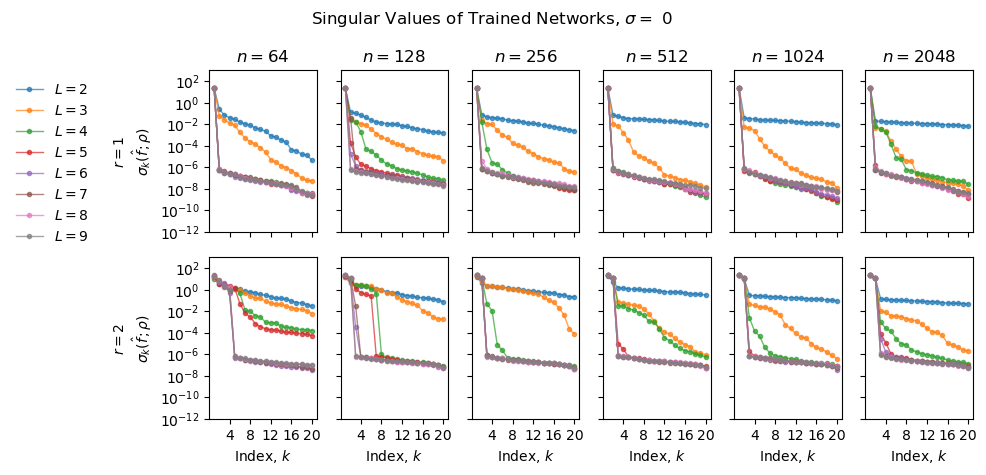

0 0
1,64,2 [2.0923059e+01 4.7731632e-01 3.2848510e-01 2.7345777e-01 2.3200534e-01
 1.0044924e-01 6.4735457e-02 4.6735670e-02 4.1192871e-02 2.8033506e-02
 1.8110830e-02 1.4201348e-02 1.2294594e-02 8.5400902e-03 7.8599583e-03
 5.6151007e-03 2.6779012e-03 2.1586404e-03 1.7372592e-03 1.1288283e-03] 0 0
0 0
1,64,3 [2.1120762e+01 8.1277418e-01 4.3553779e-01 1.8993248e-01 1.4589723e-02
 3.6647595e-03 3.0990695e-03 9.3590934e-04 3.0622090e-04 1.8559968e-04
 8.2383602e-05 5.2396066e-05 2.9655492e-05 1.0400398e-05 7.3838660e-06
 4.1860367e-06 2.6331572e-06 2.0345165e-06 5.5021832e-07 2.8727544e-07] 0 0
0 0
1,64,4 [2.13512039e+01 1.05664647e+00 3.87968063e-01 6.02444075e-02
 1.51315862e-06 6.89528690e-07 4.95657389e-07 3.95214130e-07
 2.41935908e-07 2.23807589e-07 1.51665404e-07 1.42781886e-07
 1.21754141e-07 1.11776515e-07 9.98448400e-08 9.17864398e-08
 5.67596707e-08 5.25528527e-08 4.92175403e-08 3.79793548e-08] 0 0
0 0
1,64,5 [2.1502148e+01 1.4847531e+00 5.0623465e-01 6.5863406e-07 4.4564078e-

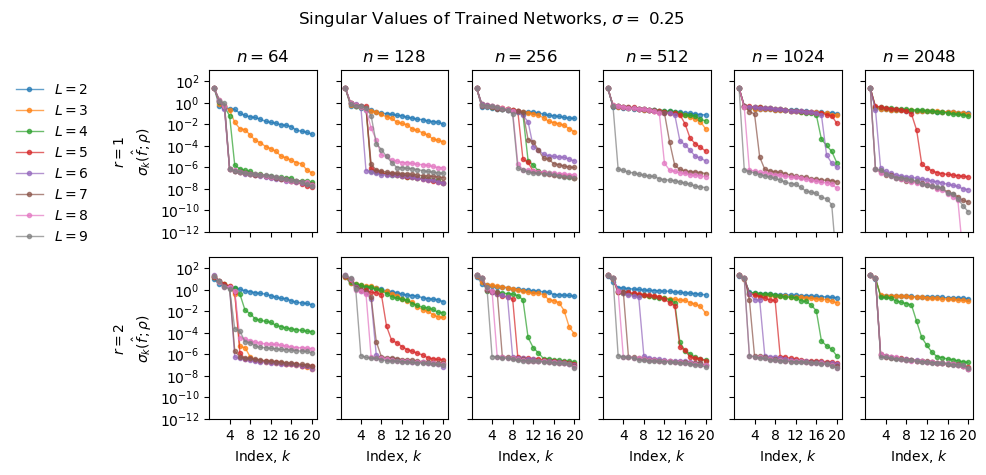

0 0
1,64,2 [2.04981136e+01 8.83279264e-01 6.12719476e-01 5.58602929e-01
 3.55309188e-01 1.78187162e-01 1.19499475e-01 8.90742540e-02
 5.59838004e-02 3.77760306e-02 3.59509103e-02 2.44974457e-02
 2.15893555e-02 1.51047707e-02 1.22343199e-02 1.02405464e-02
 6.80851936e-03 5.42348670e-03 4.29125410e-03 2.63611344e-03] 0 0
0 0
1,64,3 [2.1036610e+01 1.3587780e+00 7.7625585e-01 5.4986572e-01 1.1215372e-01
 2.2409708e-04 4.3815409e-05 2.0851608e-05 1.9211750e-05 2.5293944e-06
 1.3398212e-06 6.7276301e-07 3.8060926e-07 3.2133877e-07 2.7117366e-07
 1.6830029e-07 1.3048266e-07 1.0129434e-07 8.5281513e-08 7.4139457e-08] 0 0
0 0
1,64,4 [2.1136293e+01 1.4255176e+00 9.6083671e-01 5.9024429e-01 1.6778463e-01
 5.8424450e-04 2.6702433e-04 8.2682796e-05 4.6563666e-05 1.5254790e-05
 8.4282865e-06 3.2350958e-06 2.3096070e-06 1.5274011e-06 5.4598837e-07
 4.1973411e-07 2.4407160e-07 1.3620500e-07 8.6701021e-08 7.1504587e-08] 0 0
0 0
1,64,5 [2.1225174e+01 3.2816470e+00 1.2820210e+00 5.3227080e-07 4.4093551e-

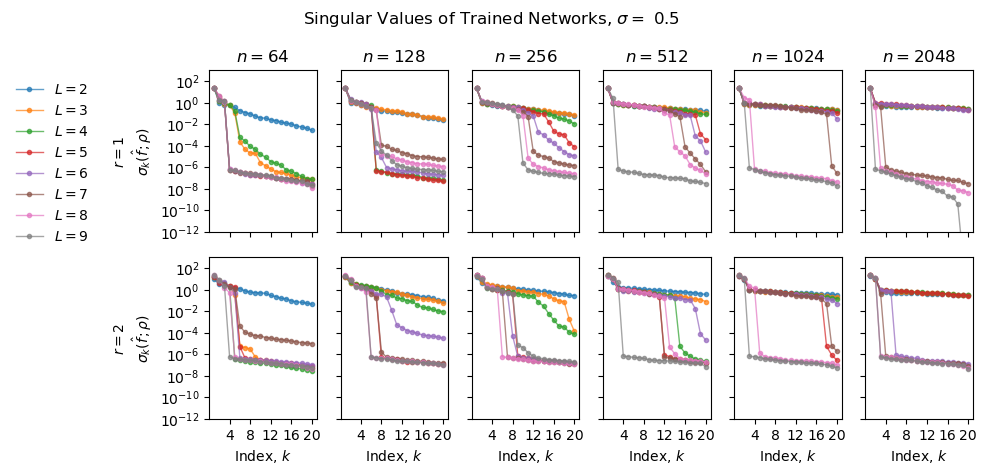

0 0
1,64,2 [1.9896650e+01 1.7568102e+00 1.2373624e+00 1.0956004e+00 5.1486474e-01
 2.6351553e-01 2.2440799e-01 1.6364118e-01 8.7633409e-02 7.9600602e-02
 6.4675041e-02 6.1927229e-02 4.1482087e-02 3.1258203e-02 1.8352002e-02
 1.6519925e-02 1.3674894e-02 1.0709276e-02 8.4582623e-03 7.4870642e-03] 0 0
0 0
1,64,3 [2.05218182e+01 1.55662858e+00 1.19362175e+00 1.01232624e+00
 8.96697640e-01 4.47575182e-01 2.26720974e-01 1.88756287e-01
 1.01232246e-01 8.62021819e-02 6.06710277e-02 5.11917211e-02
 3.57047170e-02 3.37310582e-02 2.50764843e-02 2.02342290e-02
 1.57400537e-02 1.25546223e-02 1.11211352e-02 4.98044398e-03] 0 0
0 0
1,64,4 [2.1126280e+01 2.1968670e+00 1.8800240e+00 1.2814420e+00 4.4283553e-07
 3.4141277e-07 3.2496064e-07 2.4210593e-07 1.9713617e-07 1.6474144e-07
 1.6100701e-07 1.1941886e-07 1.1076586e-07 8.0224247e-08 6.6399842e-08
 5.7098486e-08 5.2379114e-08 4.2767642e-08 3.3876660e-08 2.8642940e-08] 0 0
0 0
1,64,5 [2.1206379e+01 3.5430894e+00 2.0663581e+00 8.7249058e-01 3.9499563e-

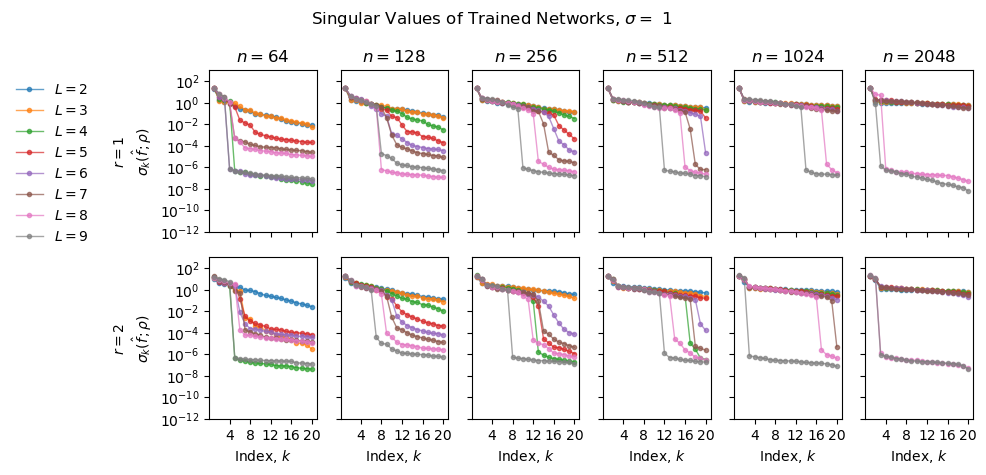

In [35]:
#all the singular values
for std in labelnoise:
    f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(10,4.8))
    for rownum,row in res.iterrows():
        if row['label noise standard deviation'] == std:
            whichrow = np.where(row['r'] == res.r.unique())[0][0]
            whichcol = np.where(row['n'] == res.n.unique())[0][0]
            print(whichrow,whichcol)
            print(rf"{row['r']},{row['n']},{row['L']}",row["Gradient Singular Values"]/np.sqrt(2048),whichrow,whichcol)
            ax[whichrow,whichcol].semilogy(row["Gradient Singular Values"]/np.sqrt(2048),label=rf"$L={row['L']}$",linewidth=1,alpha=0.7,marker=".")
            ax[whichrow,whichcol].set_xticks(list(range(3,20,4)),list(range(4,21,4)))
            ax[whichrow,whichcol].set_ylim(10**-9,10**3)
            ax[0,whichcol].set_title(rf"$n={row['n']}$")
            ax[-1,whichcol].set_xlabel(rf"Index, $k$")
    plt.subplot(2,len(res.n.unique()),1)
    leg = plt.legend()
    leg = plt.legend(bbox_to_anchor=(-1, 1))
    leg.get_frame().set_edgecolor('b')
    leg.get_frame().set_linewidth(0.0)
    plt.subplot(2,len(res.n.unique()),1)
    plt.ylabel(r"$r=1$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
    plt.yticks([10**p for p in range(-12,3,2)])
    plt.subplot(2,len(res.n.unique()),len(res.n.unique())+1)
    plt.ylabel(r"$r=2$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
    plt.yticks([10**p for p in range(-12,3,2)])
    plt.suptitle(rf"Singular Values of Trained Networks, $\sigma =$ {std}")
    plt.tight_layout()
    plt.savefig(job_name+f"_labelnoise{std}/sv.png",dpi=300)#,bbox_extra_artists=(leg,), bbox_inches='tight')
    plt.show()

## Plots of L vs Validation error

/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


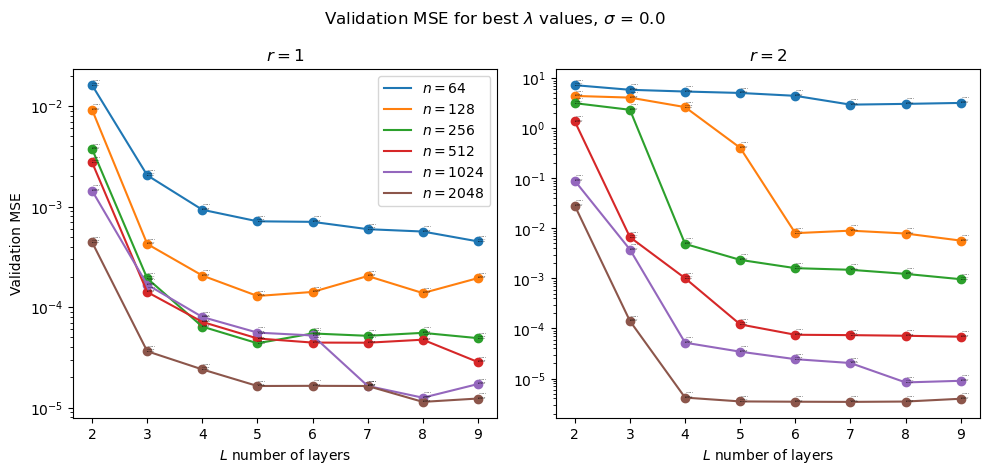

/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


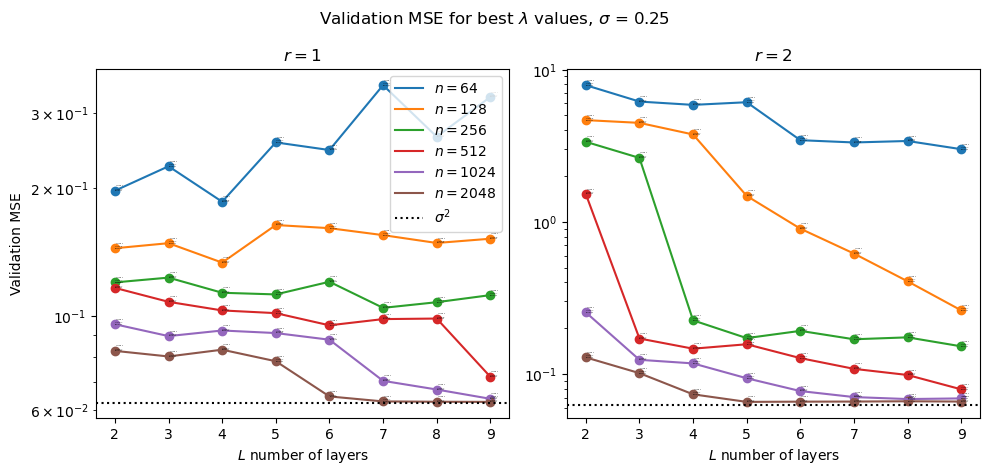

/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


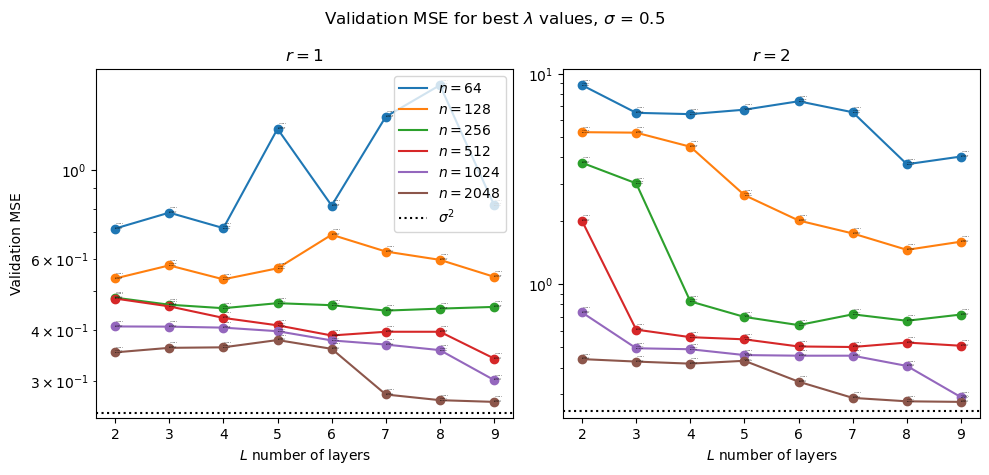

/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/sueparkinson/miniconda3/envs/cluster_startup/lib/python3.10/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


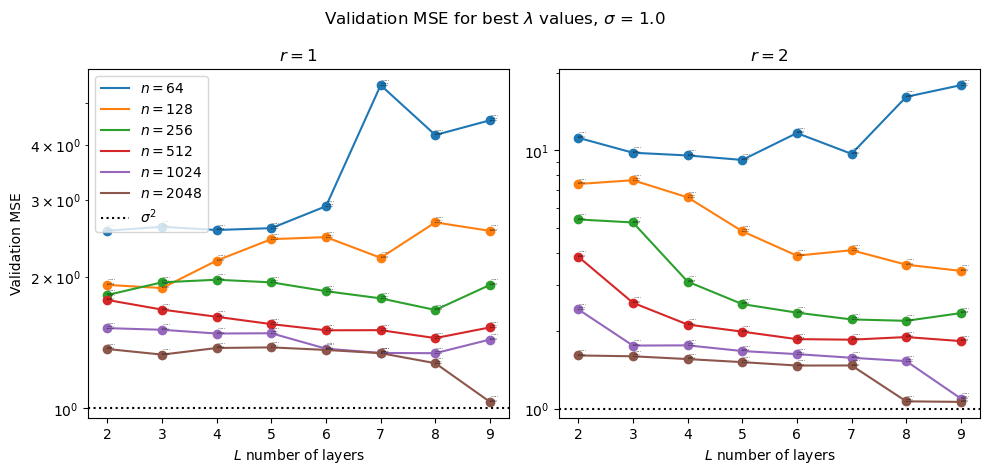

In [36]:
for std in res["label noise standard deviation"].unique():
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=False, figsize=(10,4.8))
    for rnum,r in enumerate(res.r.unique()):
        for n in res.n.unique():
                res_rnstd = res[(res.r == r) * (res.n == n) * (res["label noise standard deviation"] == std)]
                ax[rnum].scatter(res_rnstd.L,res_rnstd[["Validation MSE"]])
                ax[rnum].semilogy(res_rnstd.L,res_rnstd[["Validation MSE"]],label=rf"$n={n}$")
                for _,model in res_rnstd.iterrows():
                    text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}'
                    ax[rnum].annotate(text,[model.L,model[["Validation MSE"]]],fontsize=1)
        ax[rnum].set_xlabel("$L$ number of layers")
        ax[rnum].set_title(rf"$r={r}$")
        if std > 0:
            ax[rnum].axhline(y=std**2, color='k', linestyle=':',label="$\sigma^2$")
        ax[0].set_ylabel("Validation MSE")
        f.suptitle(rf"Validation MSE for best $\lambda$ values, $\sigma$ = {std}")
    ax[0].legend()
    f.tight_layout()
    if int(std) == std:
        std = int(std)
    f.savefig(job_name+f"_labelnoise{std}/ValidationMSE.png",dpi=300)
    plt.show()

## Performance metrics with/without linear layers

In [37]:
colors = {  
    0   :"C0",
    0.25:"C1",
    0.5 :"C2",
    1   :"C3"
}
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
labels = {
    "without linear layers":"-",
    "with linear layers"   :"--",
}
markers = {
    "without linear layers":".",
    "with linear layers"   :"x",
}
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=4) for label,ls in labels.items()
]

1 64 without linear layers 0 [2.1397243e+01 2.4623199e-01 6.6962458e-02 3.9176621e-02 2.7920175e-02
 1.5365248e-02 1.0518808e-02 8.0341594e-03 4.3791197e-03 3.1832876e-03
 2.1692181e-03 8.1623532e-04 6.0984632e-04 3.3214863e-04 2.0764796e-04
 4.0772051e-05 3.2469794e-05 1.5392319e-05 1.3646404e-05 4.2827833e-06]
1 64 with linear layers 0 [2.1651838e+01 5.0221951e-07 3.2228496e-07 2.5231301e-07 2.2004808e-07
 1.2608442e-07 8.7041407e-08 8.4286114e-08 6.2324588e-08 5.0442338e-08
 4.1343817e-08 3.4502236e-08 2.4471245e-08 2.0660952e-08 1.9601659e-08
 1.7138882e-08 9.8833057e-09 6.1149925e-09 3.2292962e-09 2.5008577e-09]
1 64 without linear layers 0.25 [2.0923059e+01 4.7731632e-01 3.2848510e-01 2.7345777e-01 2.3200534e-01
 1.0044924e-01 6.4735457e-02 4.6735670e-02 4.1192871e-02 2.8033506e-02
 1.8110830e-02 1.4201348e-02 1.2294594e-02 8.5400902e-03 7.8599583e-03
 5.6151007e-03 2.6779012e-03 2.1586404e-03 1.7372592e-03 1.1288283e-03]
1 64 with linear layers 0.25 [2.13512039e+01 1.05664647e+0

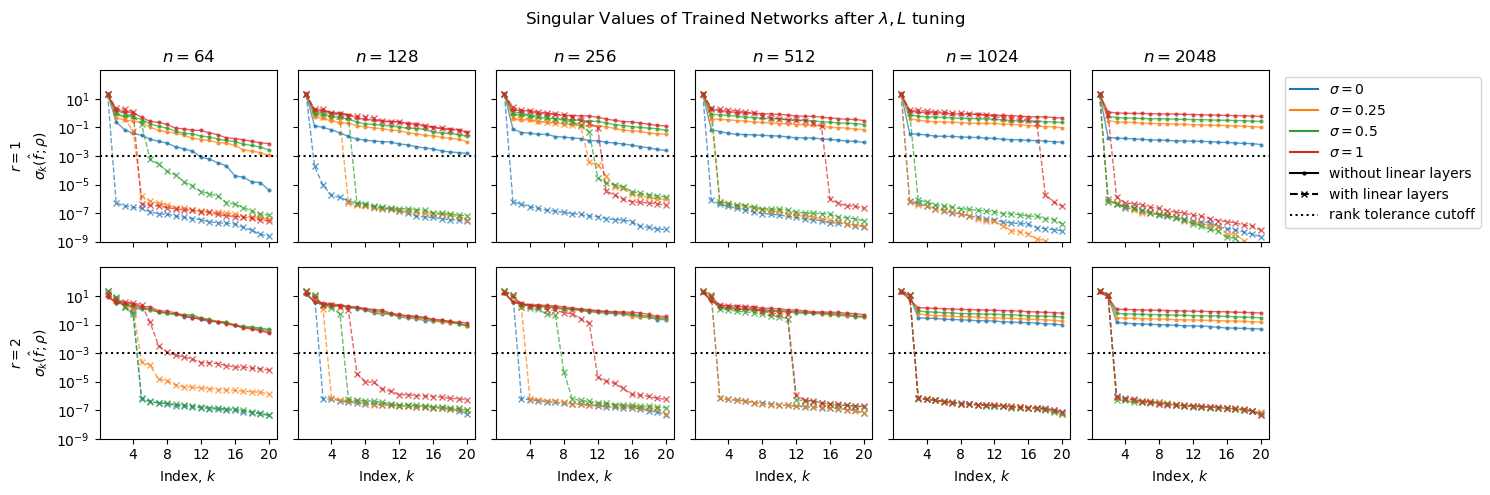

In [38]:
ranktol = 1e-3
handles += [Line2D([0], [0], color='k', ls=':', label="rank tolerance cutoff")]
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(15,5))
for row,r in enumerate(res.r.unique()):
    for col,n in enumerate(res.n.unique()):
        for sigma in labelnoise:
            for label,ls in labels.items():
                if label == "with linear layers":
                    curr = bestLres[(bestLres.r == r) * (bestLres.n == n) * (bestLres["label noise standard deviation"] == sigma)]
                elif label == "without linear layers":
                    curr = res[(res.L == 2) * (res.n == n) * (res.r == r) * (res["label noise standard deviation"]==sigma)]
                print(r,n,label,sigma,curr["Gradient Singular Values"].values[0]/np.sqrt(2048))
                marker = markers[label]
                ax[row,col].semilogy(curr["Gradient Singular Values"].values[0]/np.sqrt(2048),linestyle=ls,linewidth=1,alpha=0.7,marker=marker,markersize=4,color=colors[sigma])
        ax[row,col].axhline(y=ranktol, color='k', linestyle=':',alpha=1, label = rf"rank tolerance cutoff, $\varepsilon = {ranktol}$")
        ax[row,col].set_xticks(list(range(3,20,4)),list(range(4,21,4)))
        ax[-1,col].set_xlabel(rf"Index, $k$")
        ax[row,0].set_ylabel(rf"$r={r}$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
        ax[0,0].set_yticks([10**p for p in range(-9,3,2)])
        ax[row,col].set_ylim(10**-9,10**3)
        ax[0,col].set_title(rf"$n={n}$")
        ax[0,-1].legend(handles=handles, loc='best', bbox_to_anchor=(1.05,1))
plt.suptitle(rf"Singular Values of Trained Networks after $\lambda, L$ tuning")
plt.tight_layout()
plt.savefig(job_name+f"_labelnoise_sv.png",dpi=600)#,bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()
handles.pop()

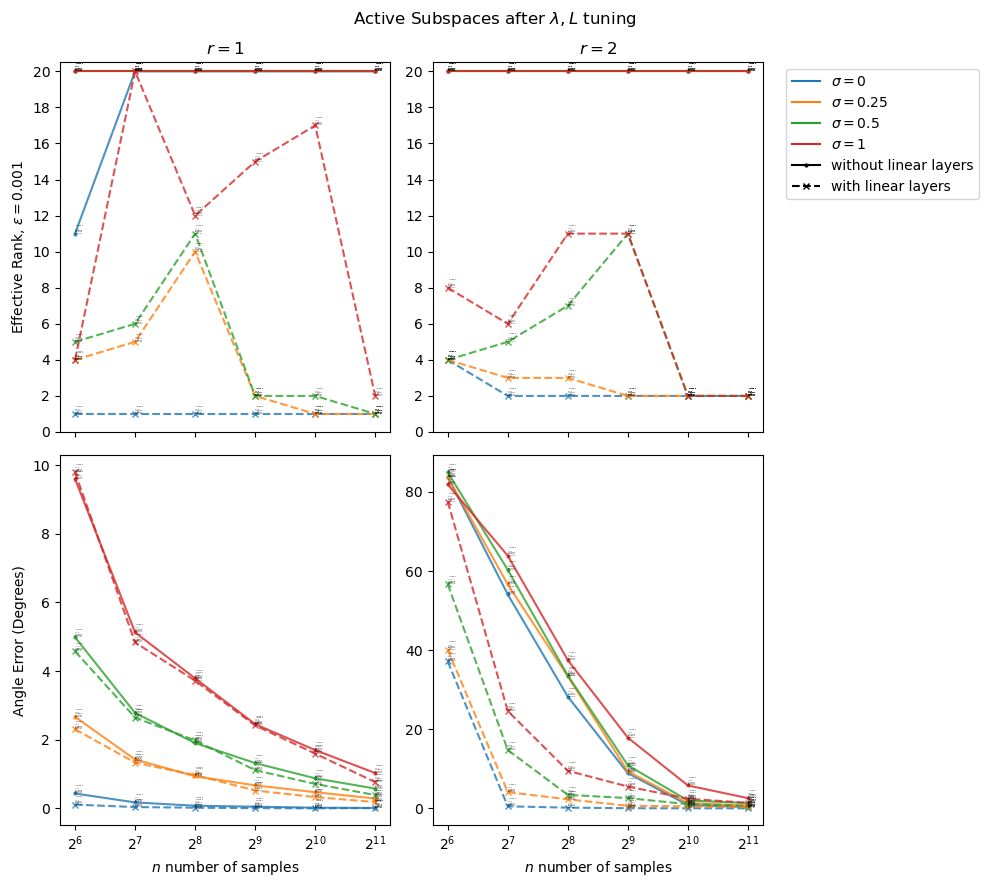

In [39]:
#active subspace error plot
f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey=False, figsize=(10,9))
for row,metric in enumerate([rf"Effective Rank, $\varepsilon = {ranktol}$","Angle Error (Degrees)"]):
    for col,r in enumerate(res.r.unique()):
        for sigma in [0,0.25,0.5,1]:
            ax[row,0].set_ylabel(f"{metric}")
            for label,ls in labels.items():
                if label == "with linear layers":
                    curr = bestLres[(bestLres.r == r) * (bestLres["label noise standard deviation"] == sigma)]
                elif label == "without linear layers":
                    curr = res[(res.L == 2) * (res.r == r) * (res["label noise standard deviation"]==sigma)]
                if metric == "Angle Error (Degrees)":
                    points = curr[[metric]].values[:,0]
                elif metric == rf"Effective Rank, $\varepsilon = {ranktol}$":
                    points = (np.array(curr["Gradient Singular Values"].tolist())/np.sqrt(2048) > ranktol).sum(axis=1)
                    ax[row,col].set_yticks(np.arange(0,21,2))
                    ax[row,col].set_ylim(0,20.5)
                marker = markers[label]
                ax[row,col].plot(curr.n,points,
                                    linestyle=ls,
                                    color=colors[sigma],
                                    marker=marker,
                                    markersize=4,
                                    alpha=0.8)
                for (_,model),y in zip(curr.iterrows(),points):
                    text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nL = {model["L"]}\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}\nVal{model["Validation MSE"]:.1e}'
                    ax[row,col].annotate(text,[model["n"],y],fontsize=1)
        #plot set up
        ax[0,col].set_title(rf"$r={r}$") 
        ax[0,1].legend(handles=handles, loc='best', bbox_to_anchor=(1.05,1))
        ax[row,col].set_xscale("log",base=2)
        ax[1,col].set_xlabel("$n$ number of samples")

plt.suptitle(f"Active Subspaces after $\lambda, L$ tuning")
plt.tight_layout()
plt.savefig(job_name+f"Active Subspaces after tuning lambda and L.png",dpi=600)
plt.show()

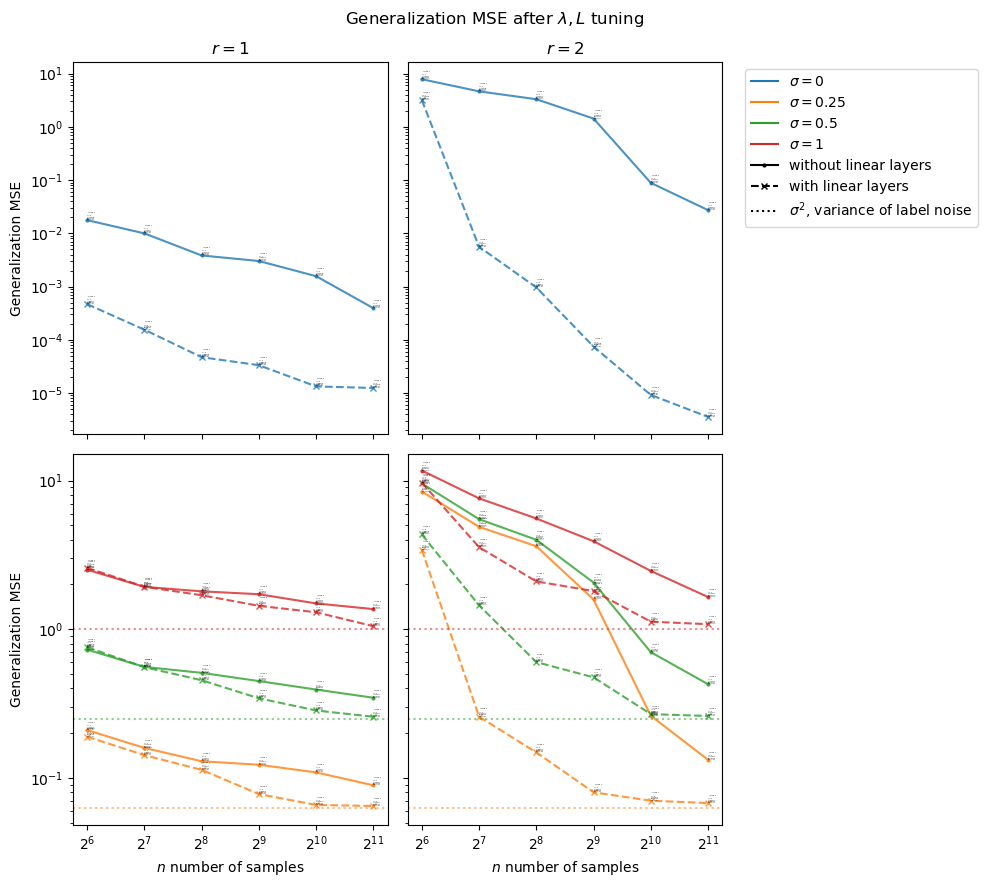

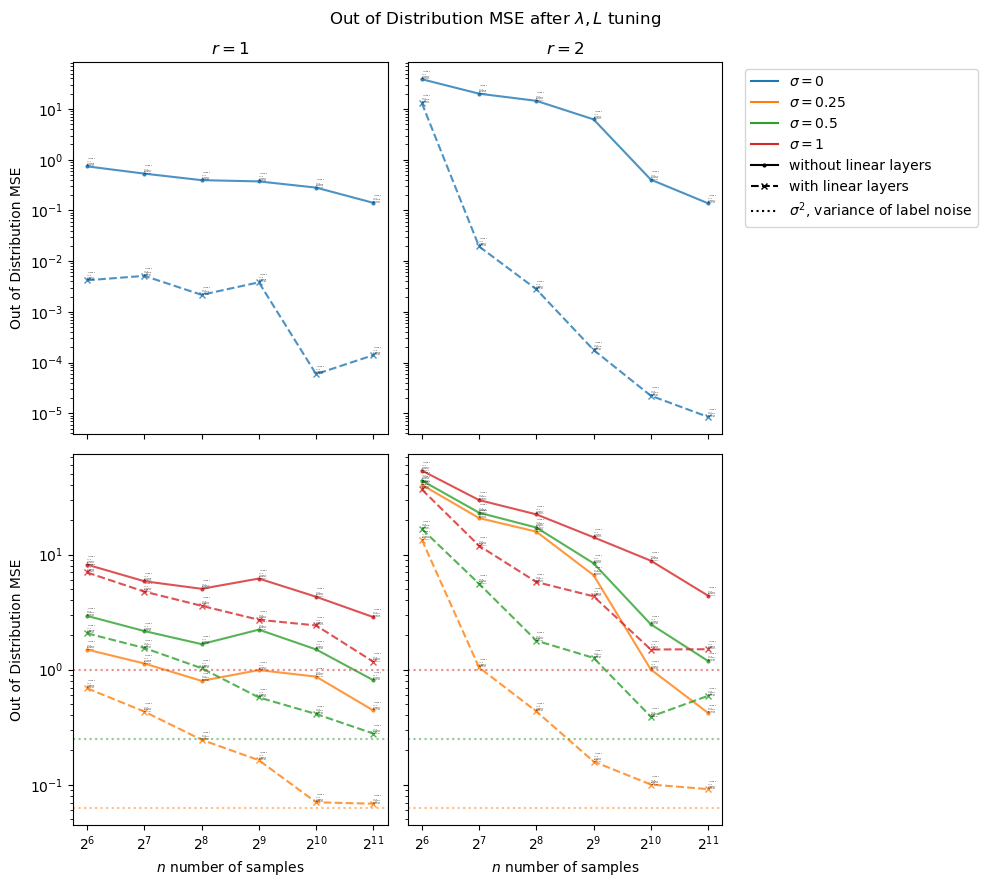

In [40]:
#generalization and OOD errors
handles += [
        Line2D([0], [0], color='k', ls=':', label='$\sigma^2$, variance of label noise'),
]

for metric in ['Generalization MSE','Out of Distribution MSE']:
    standard_errors = metric[:-3] + 'SEM'
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey="row", figsize=(10,9))
    #just the data without label noise in the first row
    for col,r in enumerate(res.r.unique()):
        for row,sigmas in enumerate([[0],[0.25,0.5,1]]):
            for sigma in sigmas:
                for label,ls in labels.items():
                    if label == "with linear layers":
                        curr = bestLres[(bestLres.r == r) * (bestLres["label noise standard deviation"] == sigma)]
                    elif label == "without linear layers":
                        curr = res[(res.L == 2) * (res.r == r) * (res["label noise standard deviation"]==sigma)]
                    points = curr[[metric]].values[:,0]
                    errorbars = curr[[standard_errors]].values[:,0]
                    marker = markers[label]
                    ax[row,col].plot(curr.n,points,
                                        linestyle=ls,
                                        marker=marker,
                                        markersize=4,
                                        color=colors[sigma],
                                        alpha=0.8)
                    #horizontal dashed line for minimal possible MSE (ie sigma^2) in plots with label noise
                    ax[1,col].axhline(y=sigma**2, color=colors[sigma], linestyle=':',alpha=0.3)
                    for (_,model),y in zip(curr.iterrows(),points):
                        text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nL = {model["L"]}\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}\nVal{model["Validation MSE"]:.1e}'
                        ax[row,col].annotate(text,[model["n"],y],fontsize=1)
            #plot set up
            ax[row,col].set_xscale("log",base=2)
            ax[row,col].set_yscale("log",base=10)
            ax[row,0].set_ylabel(f"{metric}")
            ax[0,col].set_title(rf"$r={r}$") 
            ax[1,col].set_xlabel("$n$ number of samples")
            ax[0,1].legend(handles=handles, loc='best', bbox_to_anchor=(1.05,1))
    plt.suptitle(f"{metric}" + r" after $\lambda, L$ tuning")
    plt.tight_layout()
    plt.savefig(job_name+f"{metric}.png",dpi=600)
    plt.show()

In [47]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.options.display.float_format = '{:.1e}'.format
    display(bestres.loc[:,:"Generalization MSE"].pivot_table(index=["r","label noise standard deviation","n","L"],values=["Generalization MSE"])-0.25)

Generalization MSE
r label noise standard deviation n    L                    
1 0.0e+00                        64   2            -2.3e-01
                                      9            -2.5e-01
                                 128  2            -2.4e-01
                                      5            -2.5e-01
                                 256  2            -2.5e-01
                                      5            -2.5e-01
                                 512  2            -2.5e-01
                                      9            -2.5e-01
                                 1024 2            -2.5e-01
                                      8            -2.5e-01
                                 2048 2            -2.5e-01
                                      8            -2.5e-01
  2.5e-01                        64   2            -4.0e-02
                                      4            -6.1e-02
                                 128  2            -9.1e-02
                                      4            -1.1e-01
                                 256  2            -1.2e-01
                                      7            -1.4e-01
                                 512  2            -1.3e-01
                                      9            -1.7e-01
                                 1024 2            -1.4e-01
                                      9            -1.8e-01
                                 2048 2            -1.6e-01
                                      9            -1.9e-01
  5.0e-01                        64   2             4.8e-01
                                      4             5.1e-01
                                 128  2             3.1e-01
                                      4             3.1e-01
                                 256  2             2.6e-01
                                      7             2.0e-01
                                 512  2             2.0e-01
                                      9             9.3e-02
                                 1024 2             1.4e-01
                                      9             3.4e-02
                                 2048 2             9.6e-02
                                      9             7.7e-03
  1.0e+00                        64   2             2.3e+00
                                      4             2.3e+00
                                 128  2             1.7e+00
                                      3             1.7e+00
                                 256  2             1.5e+00
                                      8             1.4e+00
                                 512  2             1.5e+00
                                      8             1.2e+00
                                 1024 2             1.2e+00
                                      8             1.1e+00
                                 2048 2             1.1e+00
                                      9             8.0e-01
2 0.0e+00                        64   2             7.6e+00
                                      7             2.9e+00
                                 128  2             4.4e+00
                                      9            -2.4e-01
                                 256  2             3.1e+00
                                      9            -2.5e-01
                                 512  2             1.2e+00
                                      9            -2.5e-01
                                 1024 2            -1.6e-01
                                      8            -2.5e-01
                                 2048 2            -2.2e-01
                                      7            -2.5e-01
  2.5e-01                        64   2             8.2e+00
                                      9             3.2e+00
                                 128  2             4.6e+00
                                      9             8.2e-03
                                 256  2             3.4e+00
                     

# Training v Epoch after Tuning $(\lambda, L)$

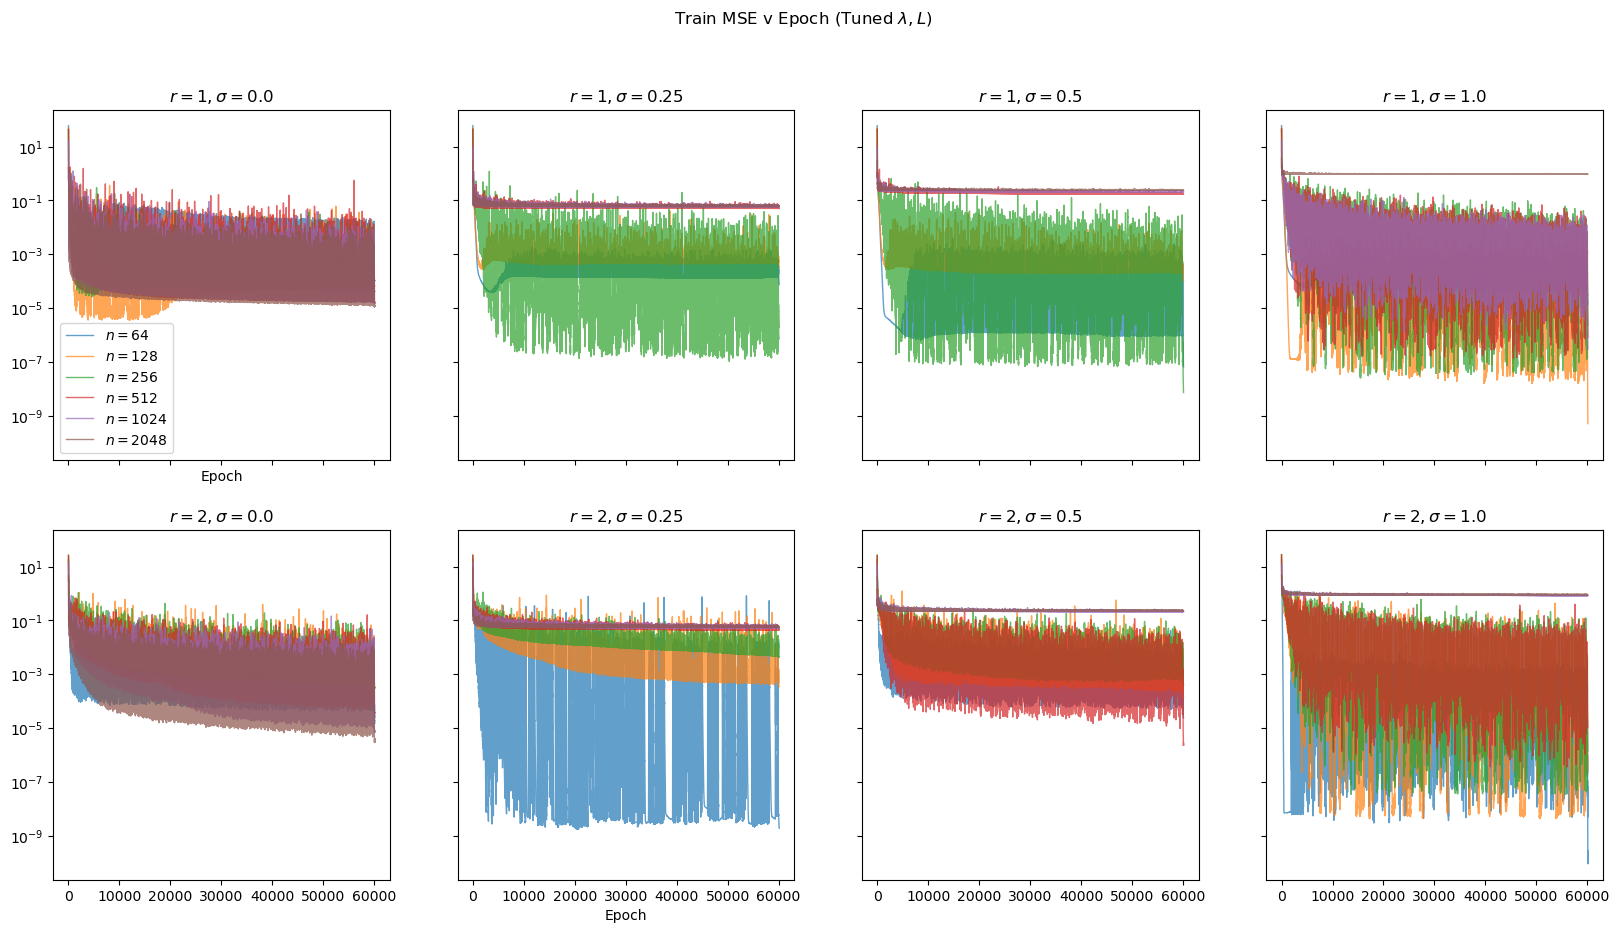

<Figure size 1000x1000 with 0 Axes>

In [42]:
sigmas = np.array([0,0.25,0.5,1])
f, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(20,10))
plt.figure(figsize=(10,10))
for rownum,row in bestLres.iterrows():
    sigma = row['label noise standard deviation']
    r = row['r']
    whichcol = np.where(sigma == sigmas)[0][0]
    whichrow = 0 if r == 1 else 1
    ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$n = {row['n']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},\sigma = {sigma}$")
    ax[whichrow,whichrow].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle(rf"Train MSE v Epoch (Tuned $\lambda,L$)")
f.savefig(job_name+f"trainmse.png",dpi=300)
plt.show()

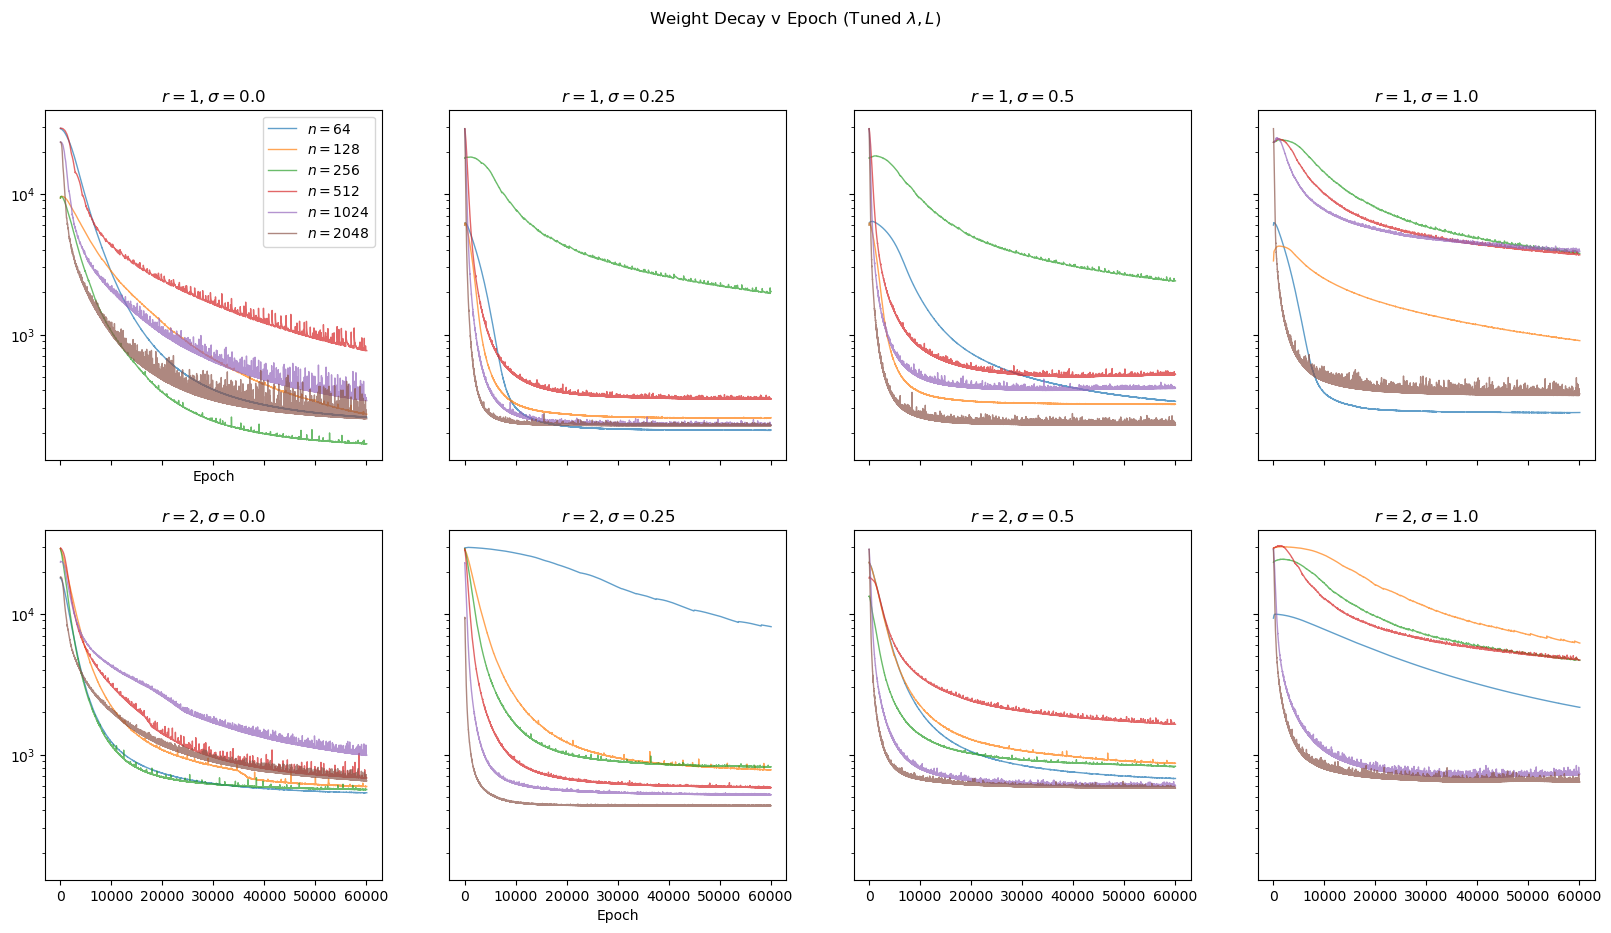

<Figure size 1000x1000 with 0 Axes>

In [43]:
sigmas = np.array([0,0.25,0.5,1])
f, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(20,10))
plt.figure(figsize=(10,10))
for rownum,row in bestLres.iterrows():
    sigma = row['label noise standard deviation']
    r = row['r']
    whichcol = np.where(sigma == sigmas)[0][0]
    whichrow = 0 if r == 1 else 1
    ax[whichrow,whichcol].semilogy(row["Weight Decay"],label=rf"$n = {row['n']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},\sigma = {sigma}$")
    ax[whichrow,whichrow].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle(rf"Weight Decay v Epoch (Tuned $\lambda,L$)")
f.savefig(job_name+f"weightdecay.png",dpi=300)
plt.show()